<a href="https://colab.research.google.com/github/Rugved-Pandit/CatchingPurple/blob/main/c8%3D26_11_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
import os
os.chdir('/content/drive/MyDrive/datasets/models/c8v4')

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# def create_generator():
#     model = tf.keras.Sequential()
    
#     # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
#     model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Reshape((7, 7, 256)))

#     model.add(layers.Conv2DTranspose(128, 3, strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

#     return model

def create_generator():
    model = tf.keras.Sequential()
    
    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7*7, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(7*7*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 4)))

    model.add(layers.Conv2DTranspose(32, 3, strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


In [ ]:
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49)                4900      
                                                                 
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 49)                0         
                                                                 
 dense_1 (Dense)             (None, 196)               9604      
                                                                 
 batch_normalization_1 (Batc  (None, 196)              784       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 196)               0

In [ ]:

def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1], activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))

    return model

In [ ]:
d=create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)             

In [ ]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:

noise_dim = 100
num_of_generated_examples = 16

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [ ]:
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([32, noise_dim])

    global generator, discriminator
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
from tqdm import tqdm

def train_GAN(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # noise= np.random.normal(loc=0, scale=1, size=[examples, 64])
    noise = tf.random.normal([100, noise_dim])
    generated_images = generator.predict(noise)
    # generated_images = generated_images.reshape(100,28,28)
    dim=(10,10)
    figsize=(10,10)
    plt.figure(figsize=figsize)
    # plt.figure()
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].reshape(28, 28), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

100%|██████████| 235/235 [00:32<00:00,  7.15it/s]


Time for epoch 1 is 32.8752236366272 sec


100%|██████████| 235/235 [00:19<00:00, 11.84it/s]


Time for epoch 2 is 19.85986614227295 sec


100%|██████████| 235/235 [00:19<00:00, 11.99it/s]


Time for epoch 3 is 19.60110116004944 sec


100%|██████████| 235/235 [00:19<00:00, 11.99it/s]


Time for epoch 4 is 19.613200664520264 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 5 is 19.47081422805786 sec


100%|██████████| 235/235 [00:19<00:00, 12.01it/s]


Time for epoch 6 is 19.571422338485718 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 7 is 19.42178177833557 sec


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Time for epoch 8 is 19.5930073261261 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 9 is 19.41411828994751 sec


100%|██████████| 235/235 [00:19<00:00, 12.03it/s]


Time for epoch 10 is 19.536779642105103 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 11 is 19.446672439575195 sec


100%|██████████| 235/235 [00:20<00:00, 11.39it/s]


Time for epoch 12 is 20.63149929046631 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 13 is 19.44239902496338 sec


100%|██████████| 235/235 [00:19<00:00, 11.98it/s]


Time for epoch 14 is 19.63007616996765 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 15 is 19.449421882629395 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 16 is 19.44412922859192 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 17 is 19.440287590026855 sec


100%|██████████| 235/235 [00:19<00:00, 12.01it/s]


Time for epoch 18 is 19.574326992034912 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 19 is 19.469757318496704 sec


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Time for epoch 20 is 19.58668279647827 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Time for epoch 21 is 19.412334442138672 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 22 is 19.433478593826294 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 23 is 19.49808168411255 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 24 is 19.42776584625244 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 25 is 19.4078471660614 sec


100%|██████████| 235/235 [00:19<00:00, 12.05it/s]


Time for epoch 26 is 19.50887656211853 sec


100%|██████████| 235/235 [00:19<00:00, 12.08it/s]


Time for epoch 27 is 19.454496145248413 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 28 is 19.49222421646118 sec


100%|██████████| 235/235 [00:19<00:00, 12.08it/s]


Time for epoch 29 is 19.457943439483643 sec


100%|██████████| 235/235 [00:19<00:00, 12.03it/s]


Time for epoch 30 is 19.54952096939087 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 31 is 19.488813161849976 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 32 is 19.412797212600708 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 33 is 19.395386695861816 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 34 is 19.41869020462036 sec


100%|██████████| 235/235 [00:19<00:00, 12.02it/s]


Time for epoch 35 is 19.555607080459595 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 36 is 19.44163966178894 sec


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Time for epoch 37 is 19.593364477157593 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 38 is 19.406489849090576 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 39 is 19.401465892791748 sec


100%|██████████| 235/235 [00:19<00:00, 12.04it/s]


Time for epoch 40 is 19.532182931900024 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 41 is 19.39980149269104 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 42 is 19.40570902824402 sec


100%|██████████| 235/235 [00:19<00:00, 12.01it/s]


Time for epoch 43 is 19.57275629043579 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 44 is 19.3917293548584 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 45 is 19.467769384384155 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 46 is 19.43317198753357 sec


100%|██████████| 235/235 [00:19<00:00, 12.05it/s]


Time for epoch 47 is 19.500061988830566 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 48 is 19.376734018325806 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 49 is 19.415286779403687 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 50 is 19.4978187084198 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 51 is 19.37644934654236 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 52 is 19.424054622650146 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 53 is 19.4902925491333 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 54 is 19.472929000854492 sec


100%|██████████| 235/235 [00:19<00:00, 12.05it/s]


Time for epoch 55 is 19.506686687469482 sec


100%|██████████| 235/235 [00:19<00:00, 12.08it/s]


Time for epoch 56 is 19.46031165122986 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 57 is 19.487911462783813 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 58 is 19.384483337402344 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 59 is 19.42949867248535 sec


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Time for epoch 60 is 19.583940744400024 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 61 is 19.41285729408264 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 62 is 19.412238836288452 sec


100%|██████████| 235/235 [00:19<00:00, 12.05it/s]


Time for epoch 63 is 19.514872074127197 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 64 is 19.381367444992065 sec


100%|██████████| 235/235 [00:19<00:00, 12.14it/s]


Time for epoch 65 is 19.36090350151062 sec


100%|██████████| 235/235 [00:20<00:00, 11.36it/s]


Time for epoch 66 is 20.697582006454468 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 67 is 19.420539617538452 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 68 is 19.417250156402588 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 69 is 19.431283235549927 sec


100%|██████████| 235/235 [00:19<00:00, 12.03it/s]


Time for epoch 70 is 19.533979654312134 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 71 is 19.405463457107544 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 72 is 19.476410627365112 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 73 is 19.448519229888916 sec


100%|██████████| 235/235 [00:19<00:00, 12.14it/s]


Time for epoch 74 is 19.358373403549194 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 75 is 19.483264684677124 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 76 is 19.433451414108276 sec


100%|██████████| 235/235 [00:19<00:00, 12.14it/s]


Time for epoch 77 is 19.36188054084778 sec


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Time for epoch 78 is 19.592597007751465 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 79 is 19.393051385879517 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 80 is 19.389463663101196 sec


100%|██████████| 235/235 [00:19<00:00, 12.04it/s]


Time for epoch 81 is 19.531487703323364 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 82 is 19.386202335357666 sec


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Time for epoch 83 is 19.591073989868164 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 84 is 19.402024269104004 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 85 is 19.393635511398315 sec


100%|██████████| 235/235 [00:19<00:00, 12.04it/s]


Time for epoch 86 is 19.521995306015015 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 87 is 19.432210206985474 sec


100%|██████████| 235/235 [00:19<00:00, 12.08it/s]


Time for epoch 88 is 19.4578857421875 sec


100%|██████████| 235/235 [00:19<00:00, 12.09it/s]


Time for epoch 89 is 19.441072702407837 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 90 is 19.40644121170044 sec


100%|██████████| 235/235 [00:19<00:00, 12.07it/s]


Time for epoch 91 is 19.481350421905518 sec


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Time for epoch 92 is 19.431307315826416 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 93 is 19.37187695503235 sec


100%|██████████| 235/235 [00:19<00:00, 12.08it/s]


Time for epoch 94 is 19.45494818687439 sec


100%|██████████| 235/235 [00:19<00:00, 12.08it/s]


Time for epoch 95 is 19.461113691329956 sec


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Time for epoch 96 is 19.381673336029053 sec


100%|██████████| 235/235 [00:20<00:00, 11.41it/s]


Time for epoch 97 is 20.60719060897827 sec


100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Time for epoch 98 is 19.391182899475098 sec


100%|██████████| 235/235 [00:19<00:00, 12.06it/s]


Time for epoch 99 is 19.49723172187805 sec


100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Time for epoch 100 is 19.40689492225647 sec


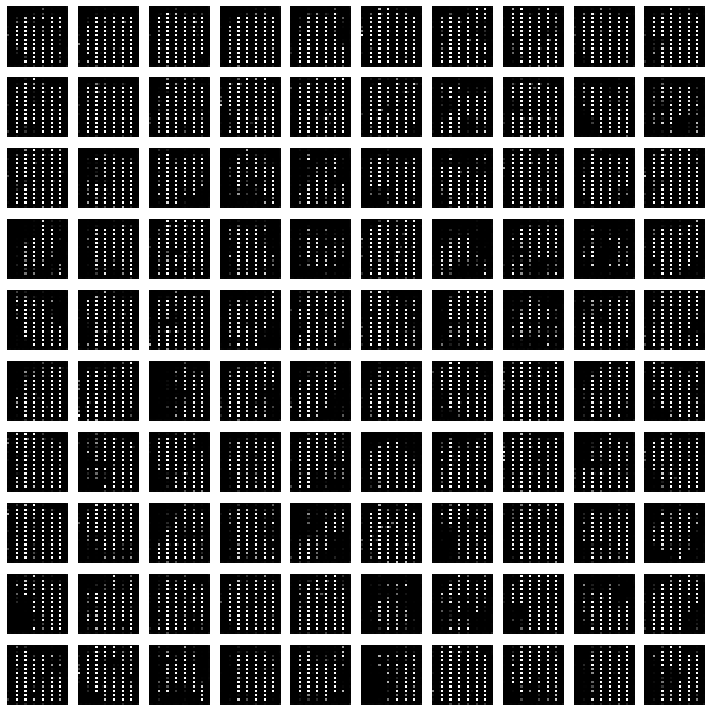

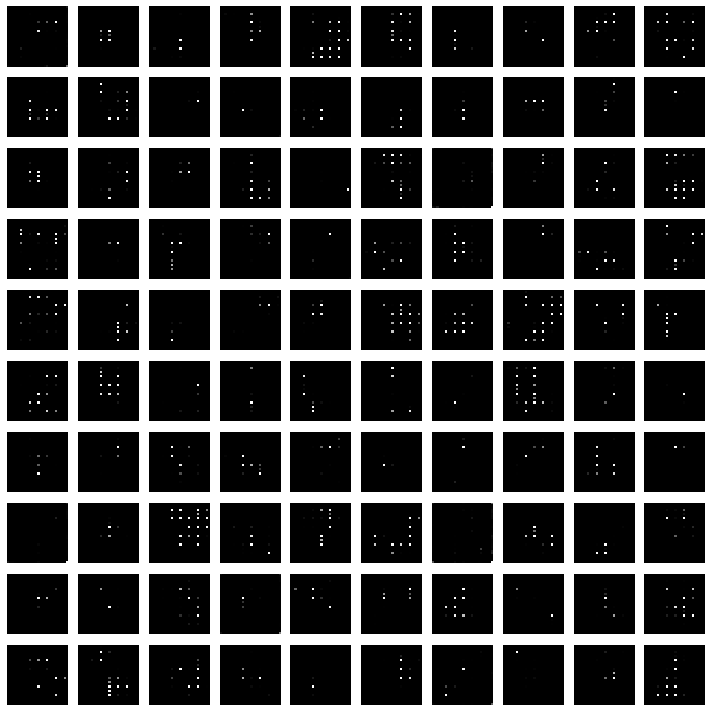

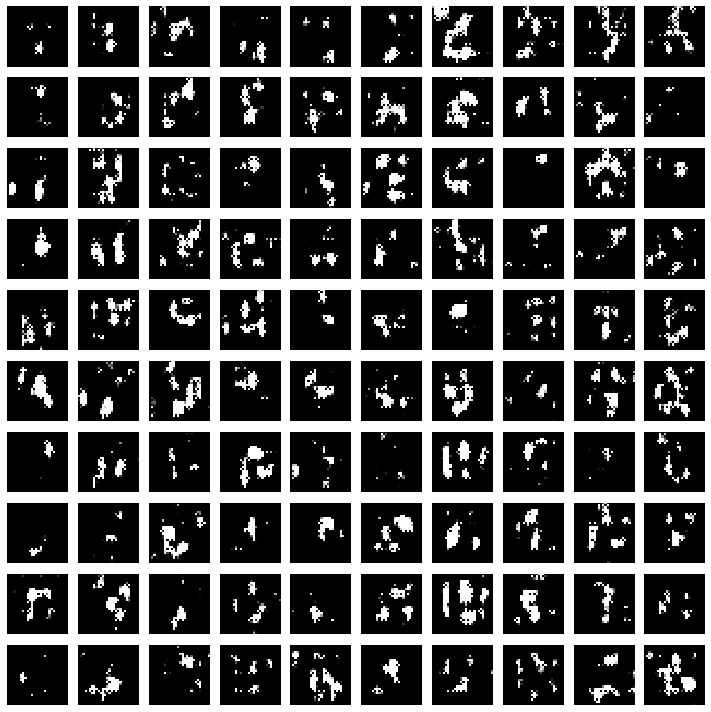

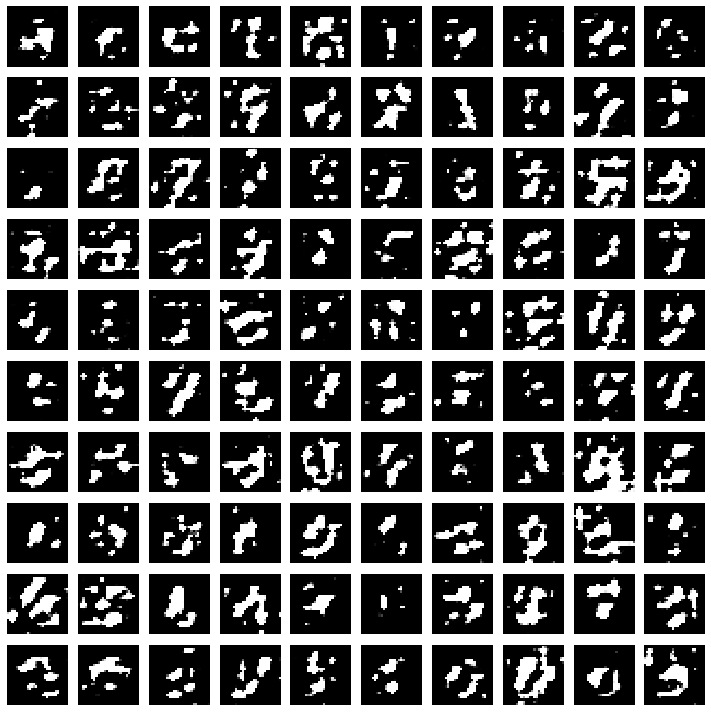

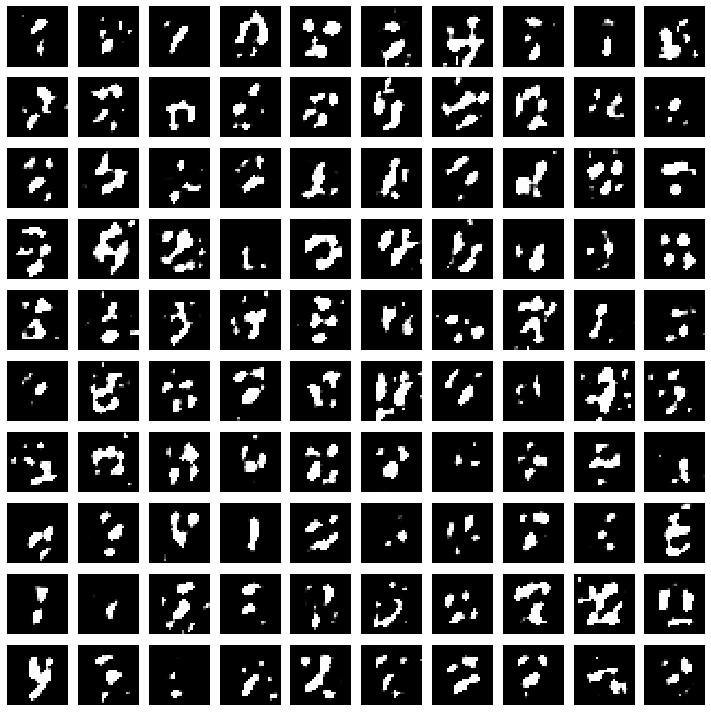

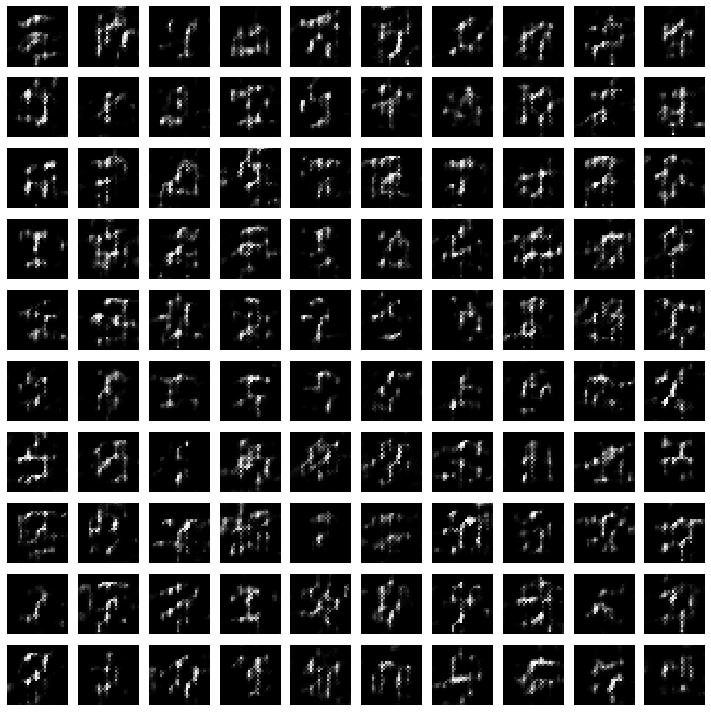

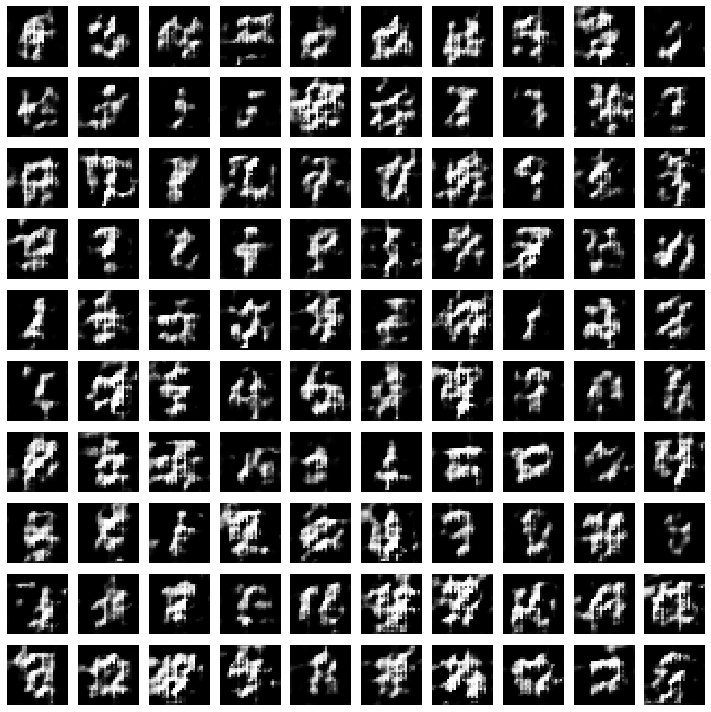

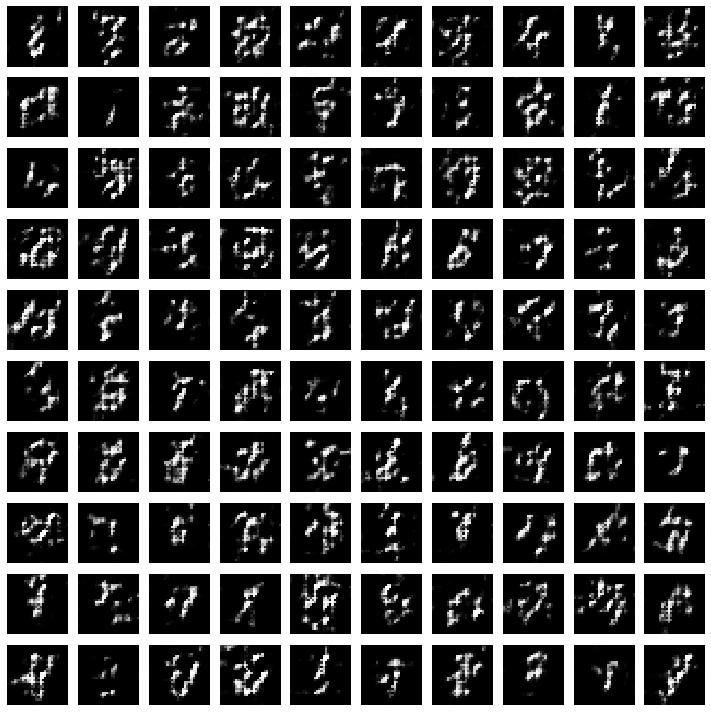

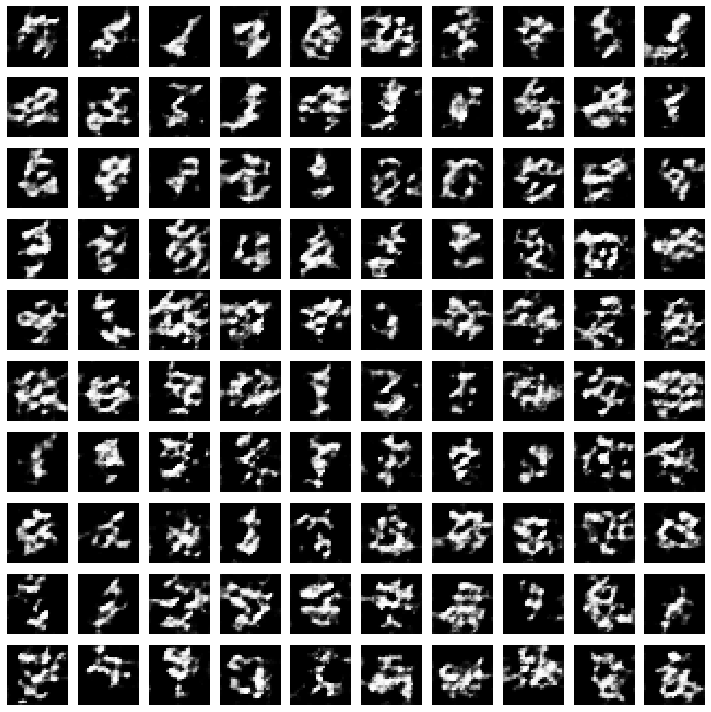

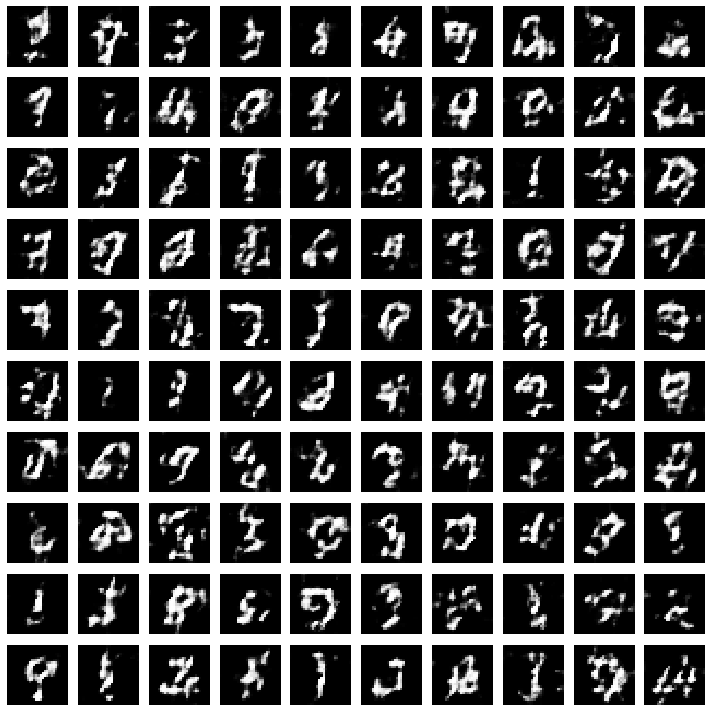

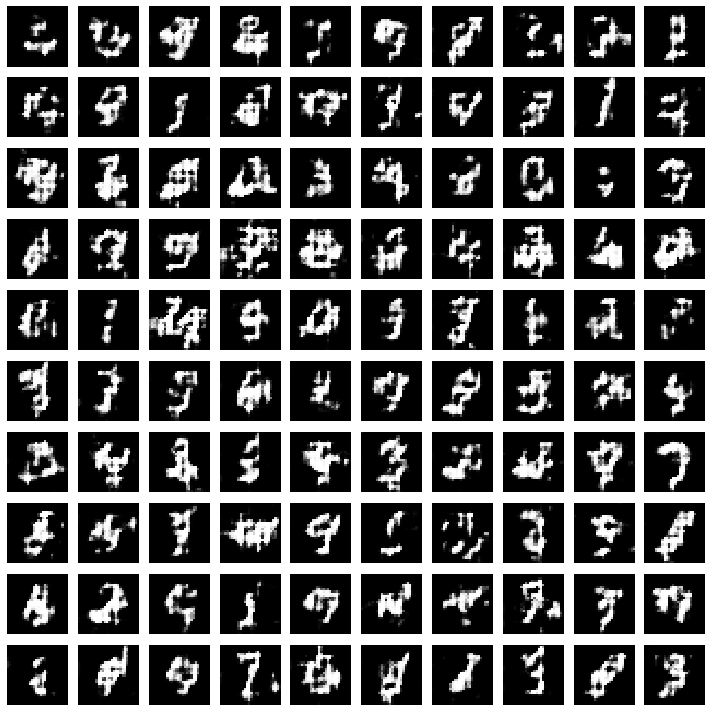

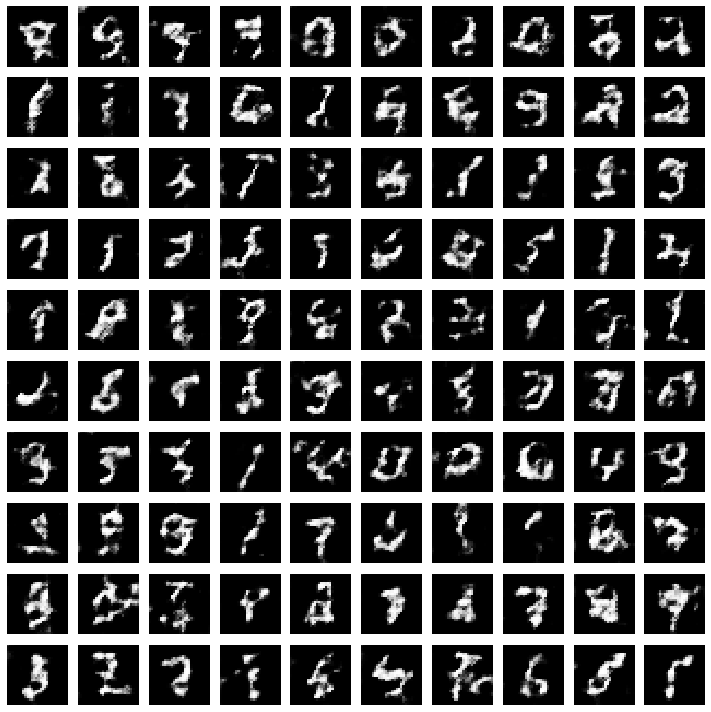

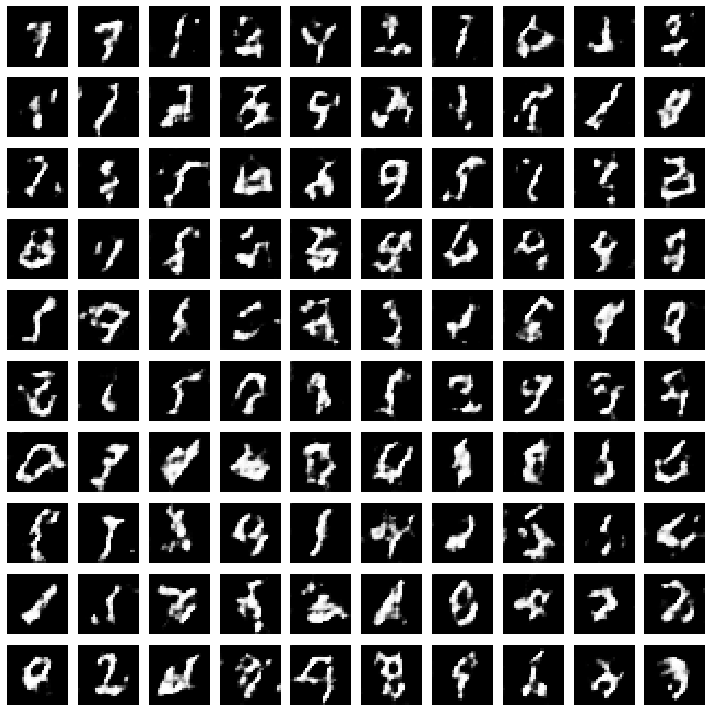

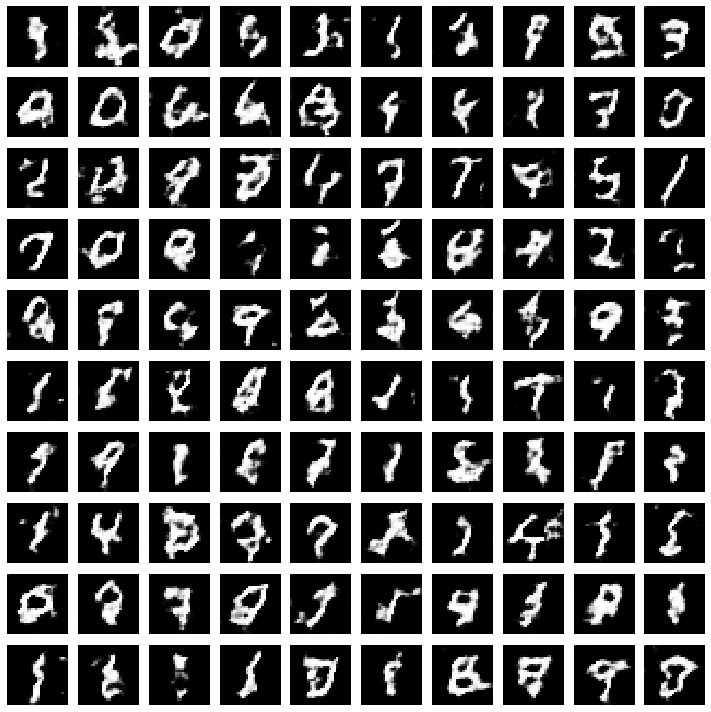

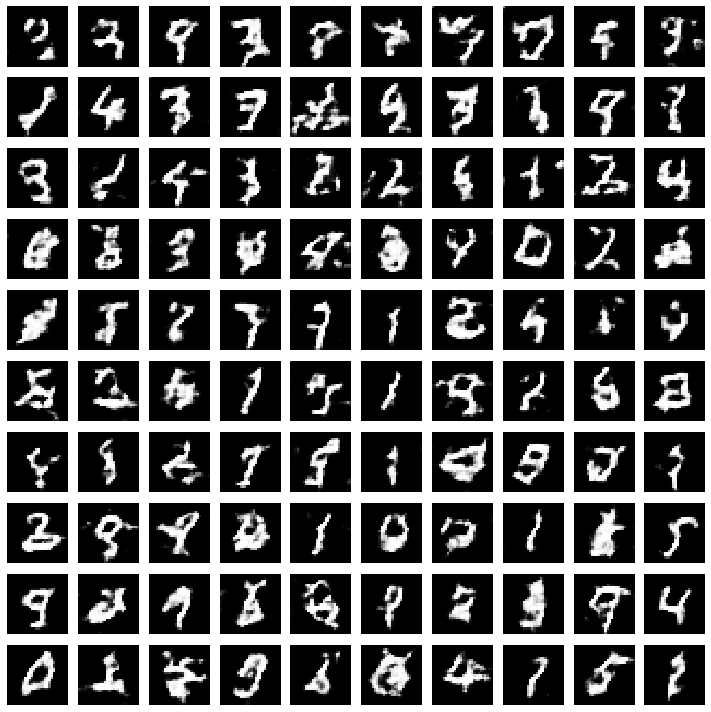

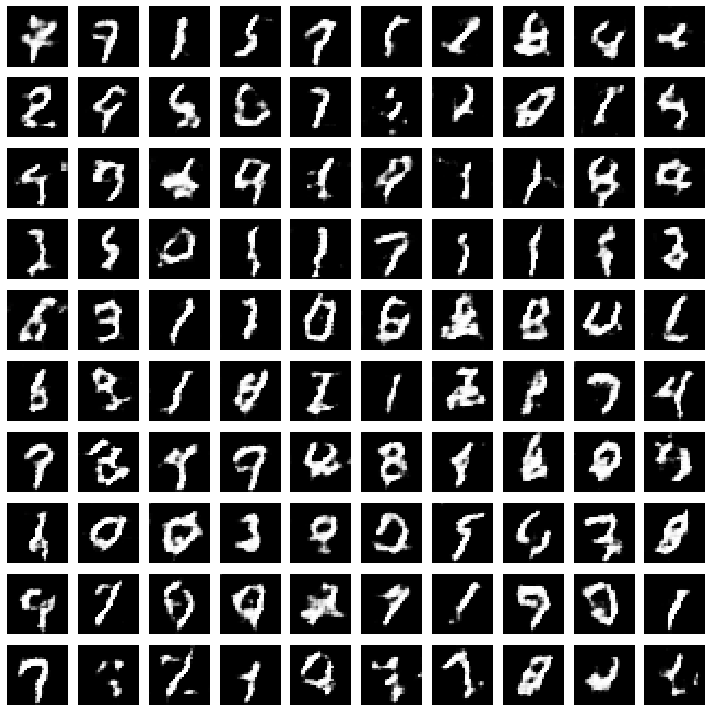

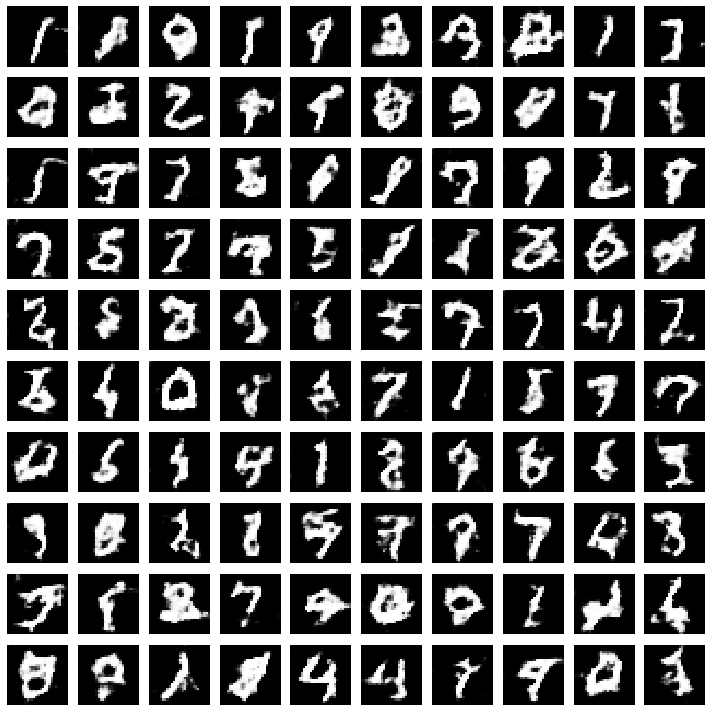

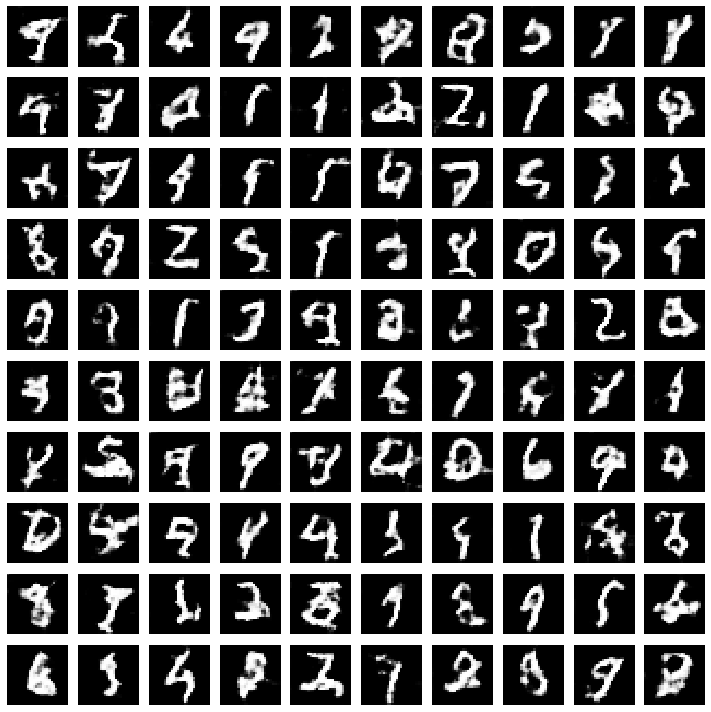

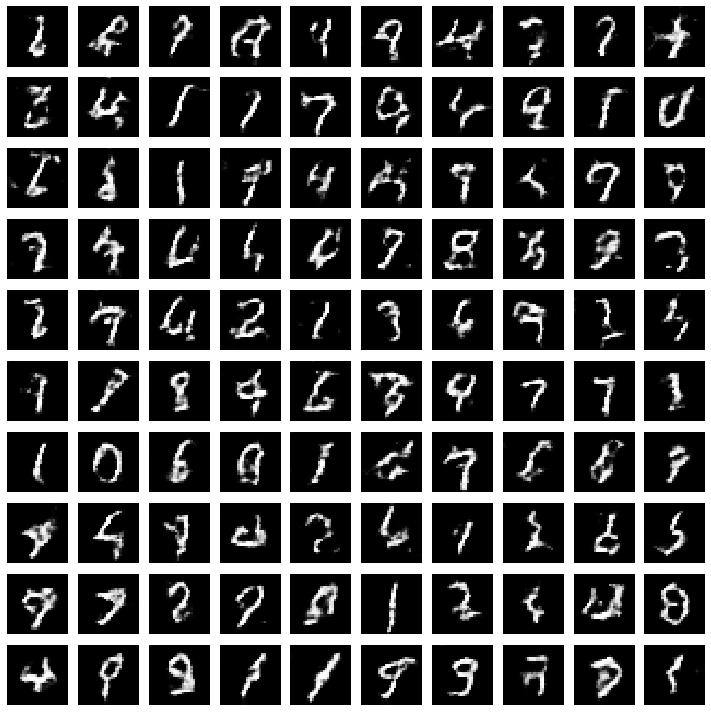

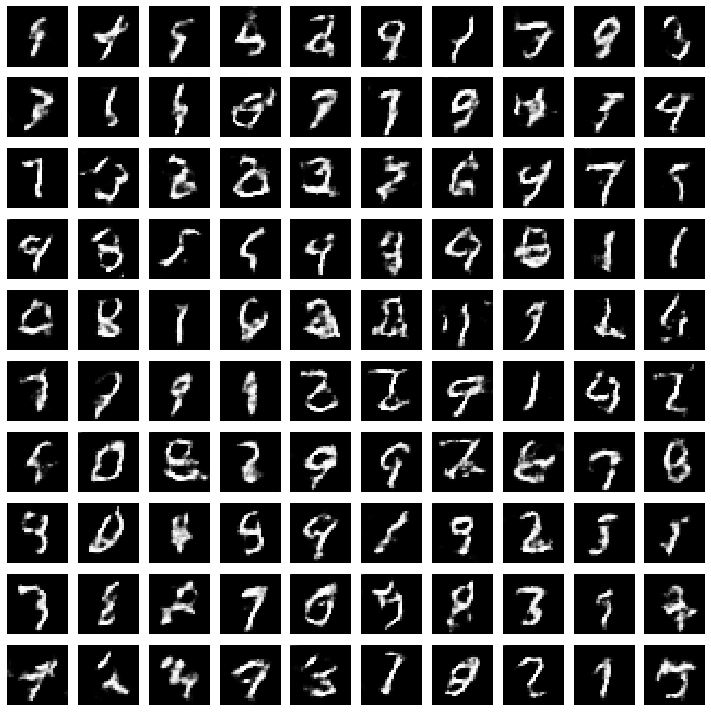

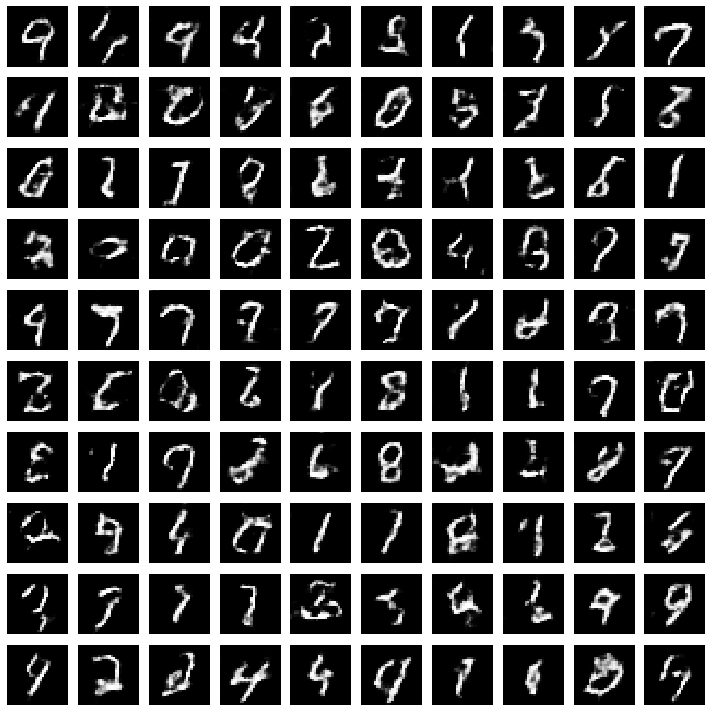

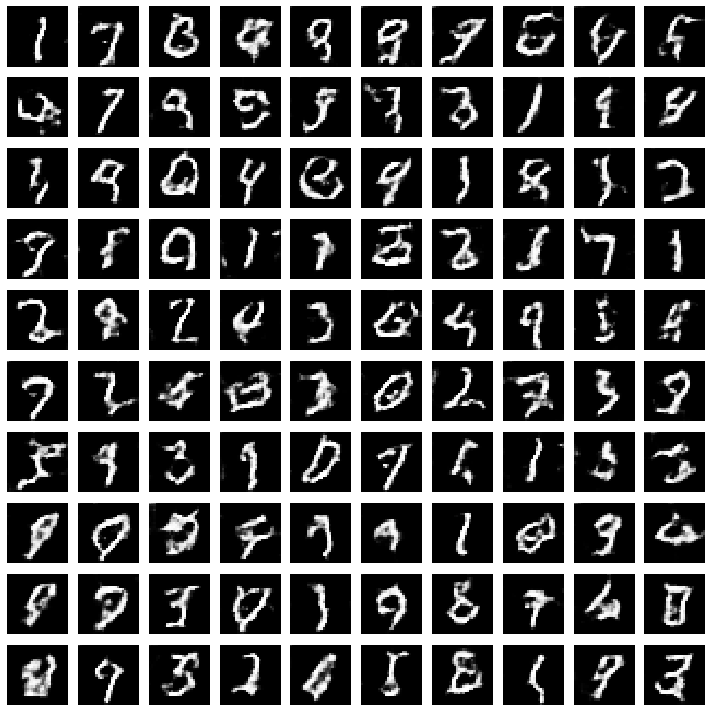

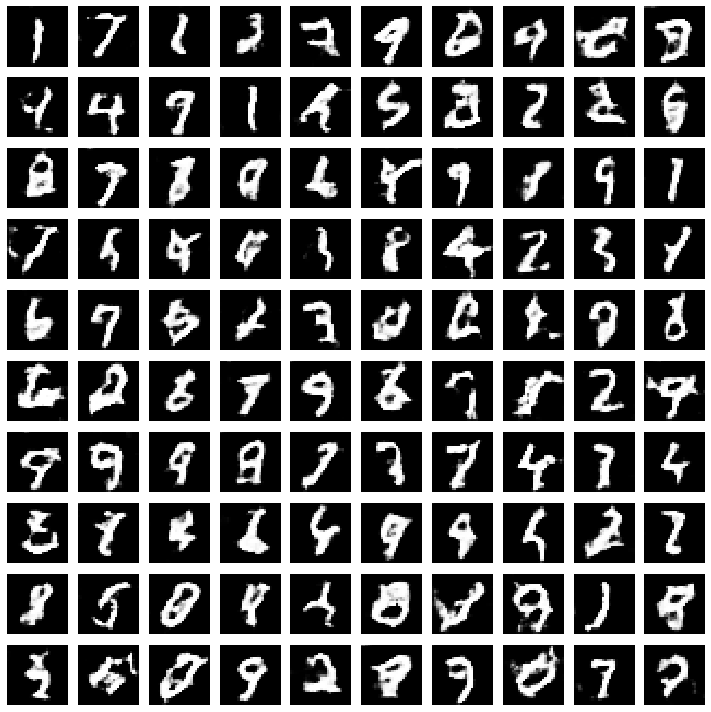

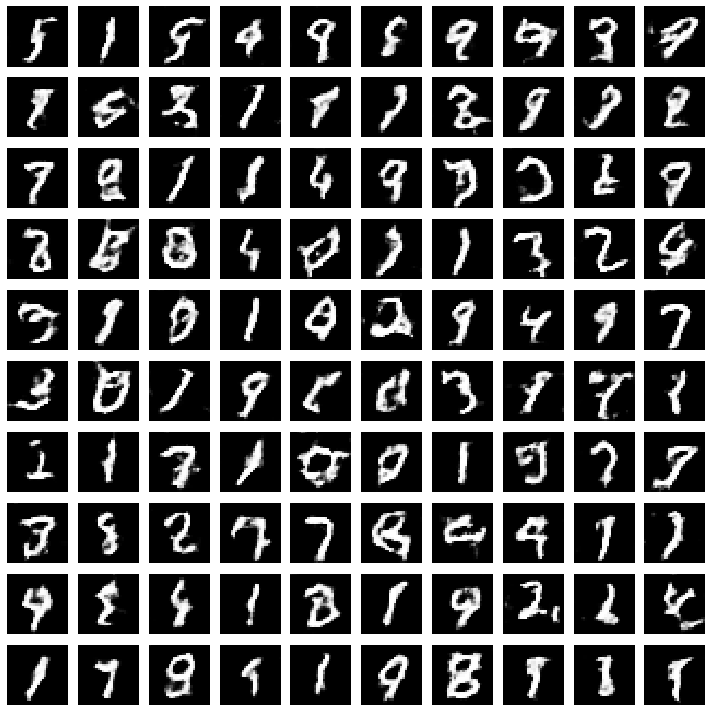

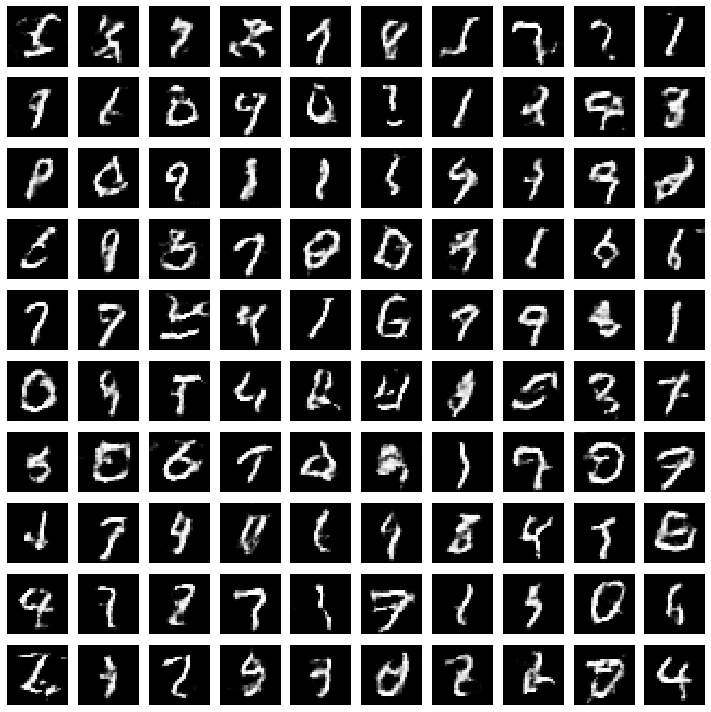

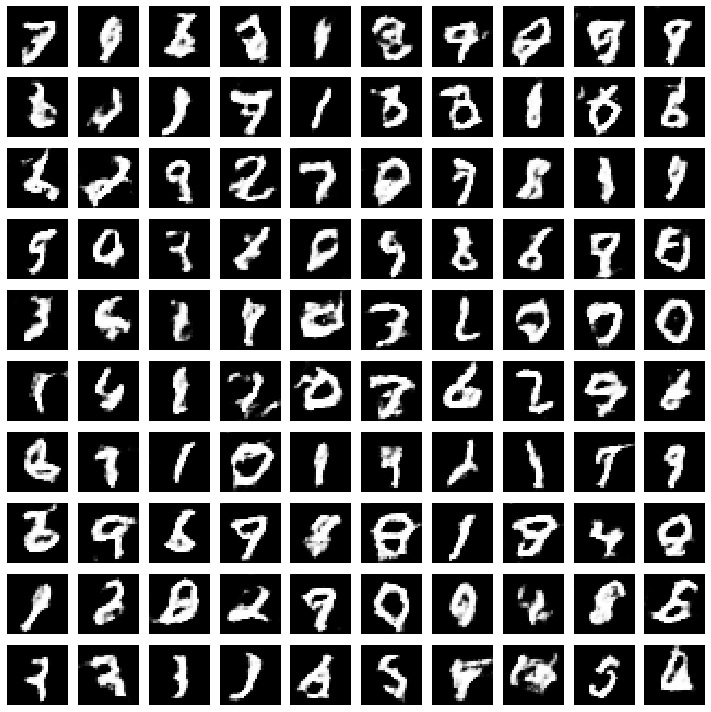

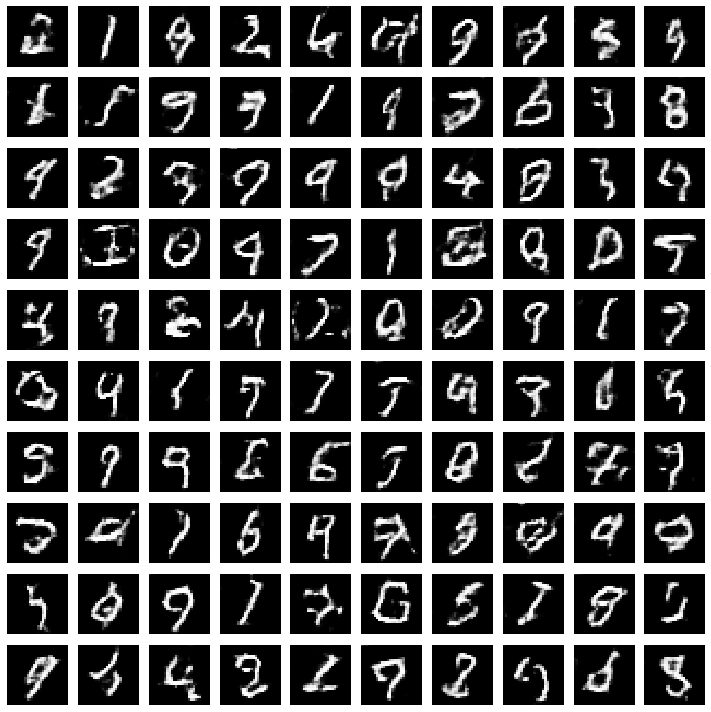

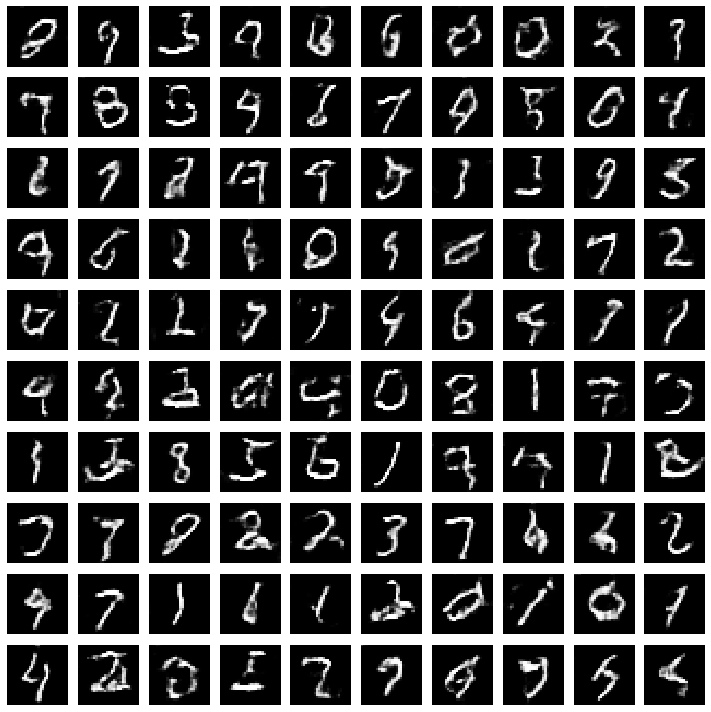

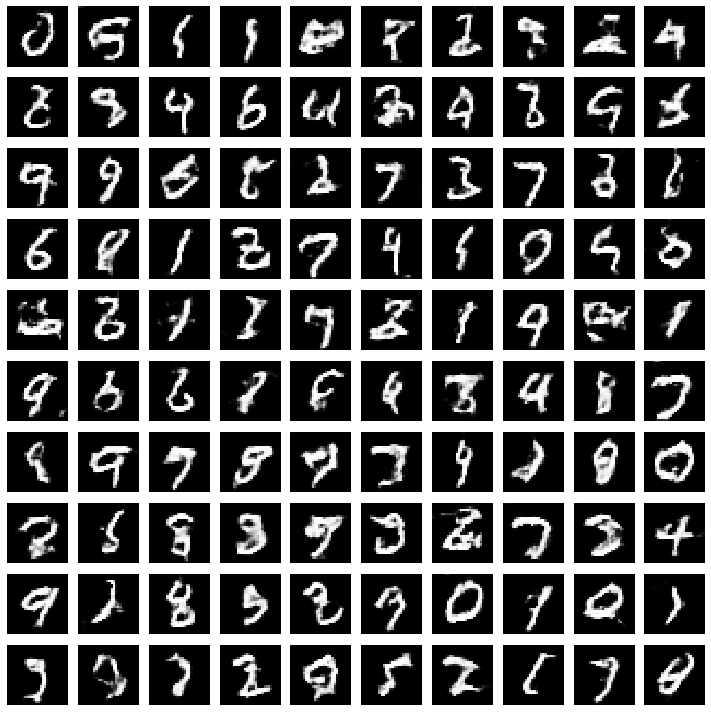

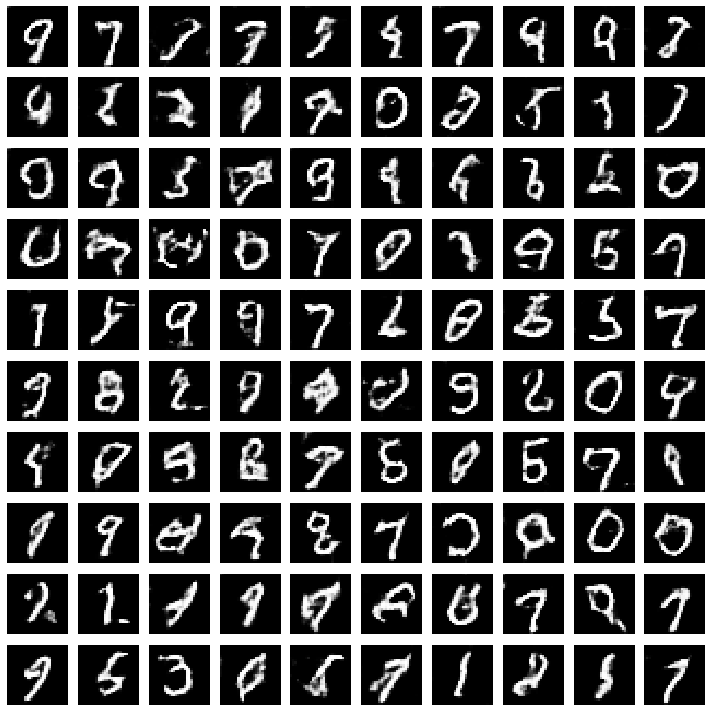

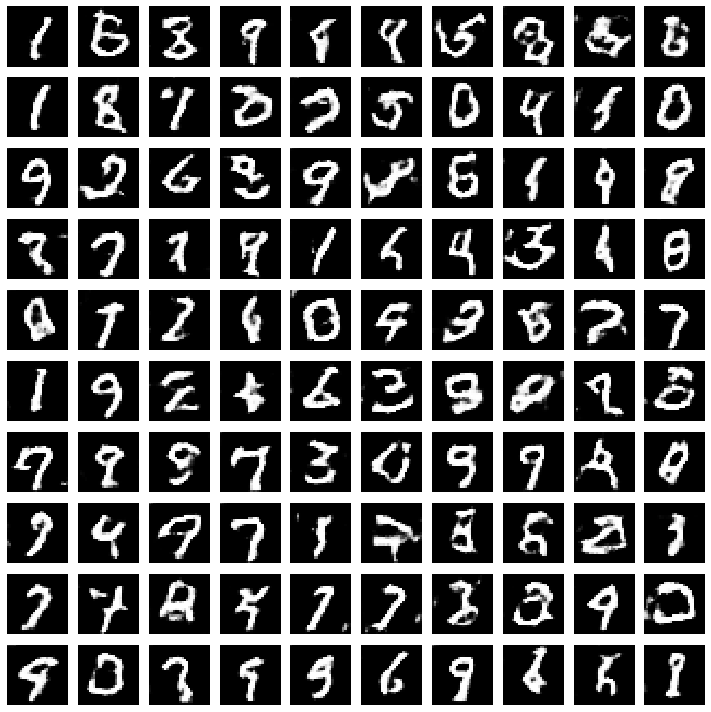

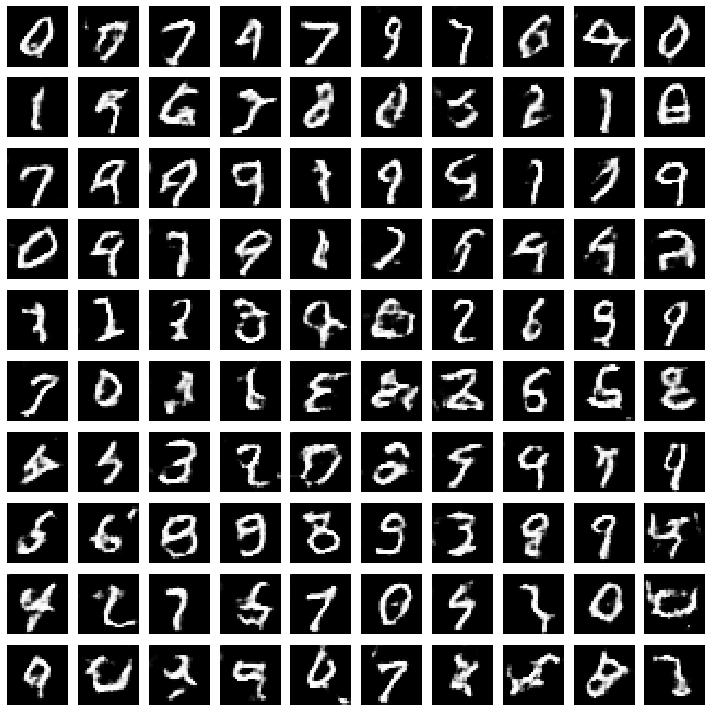

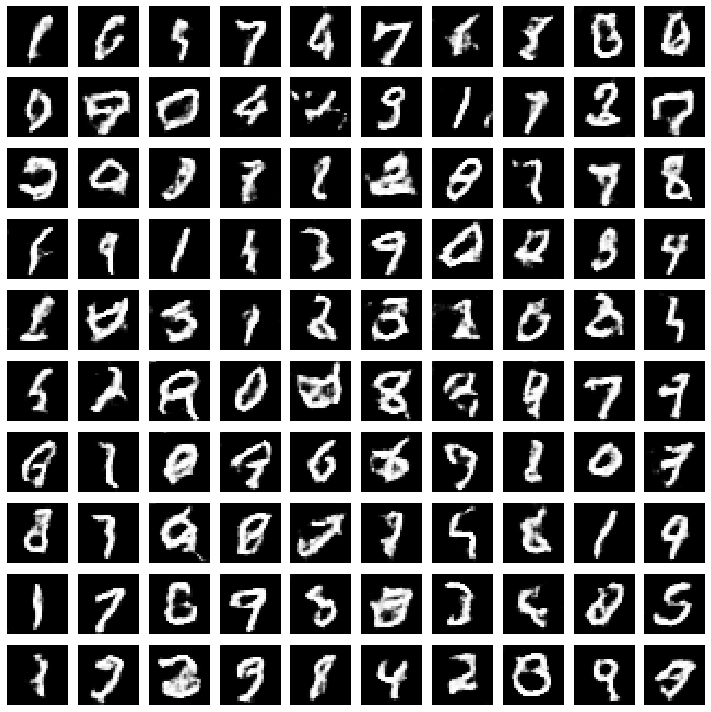

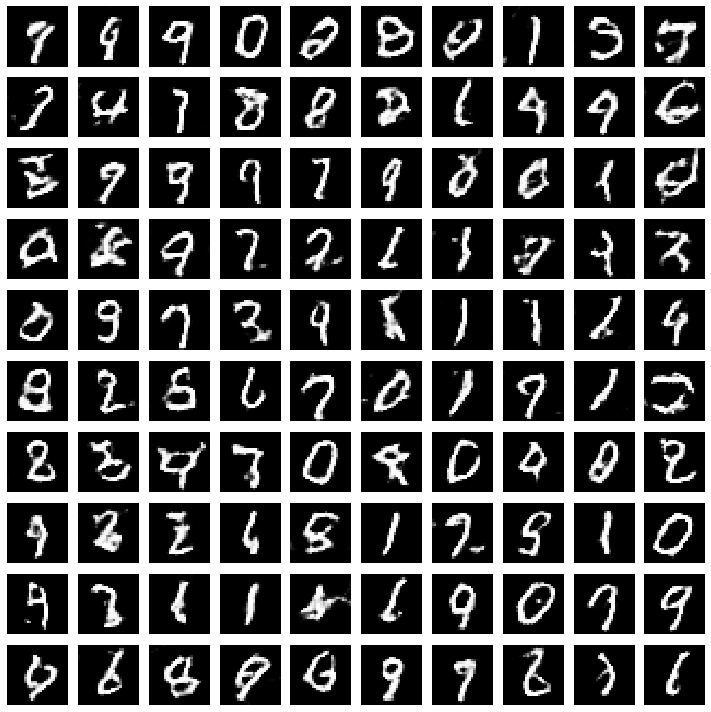

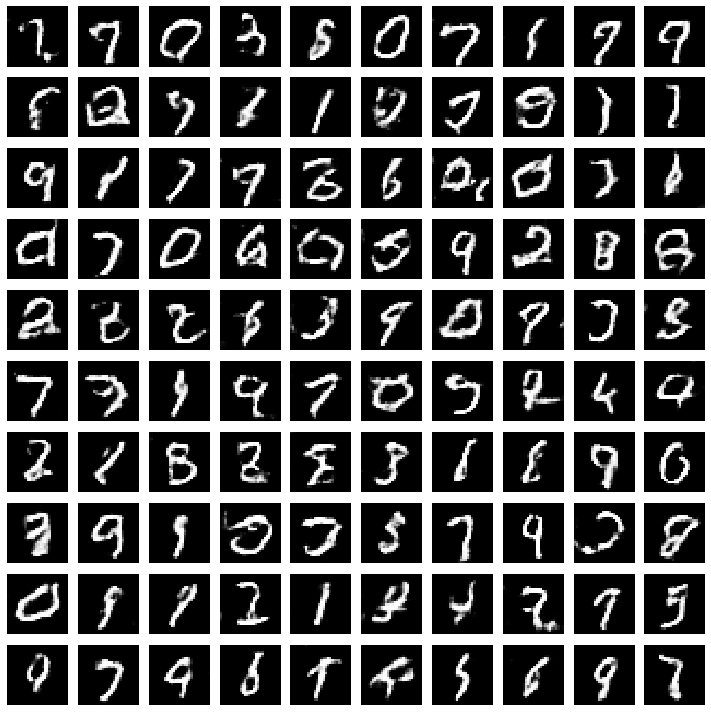

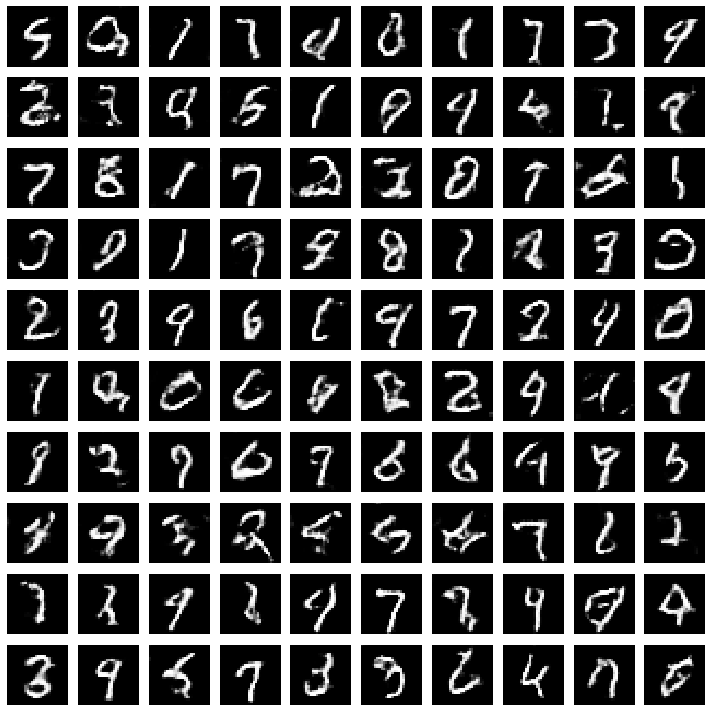

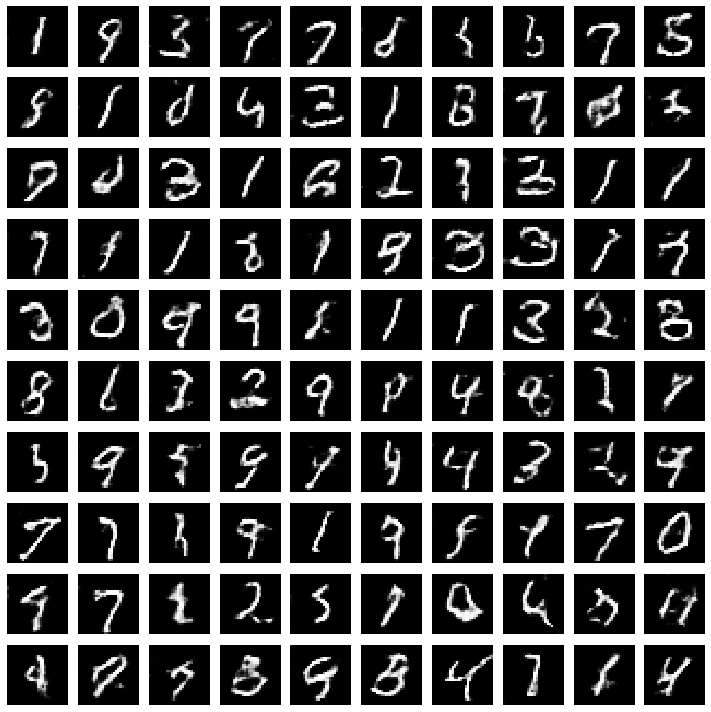

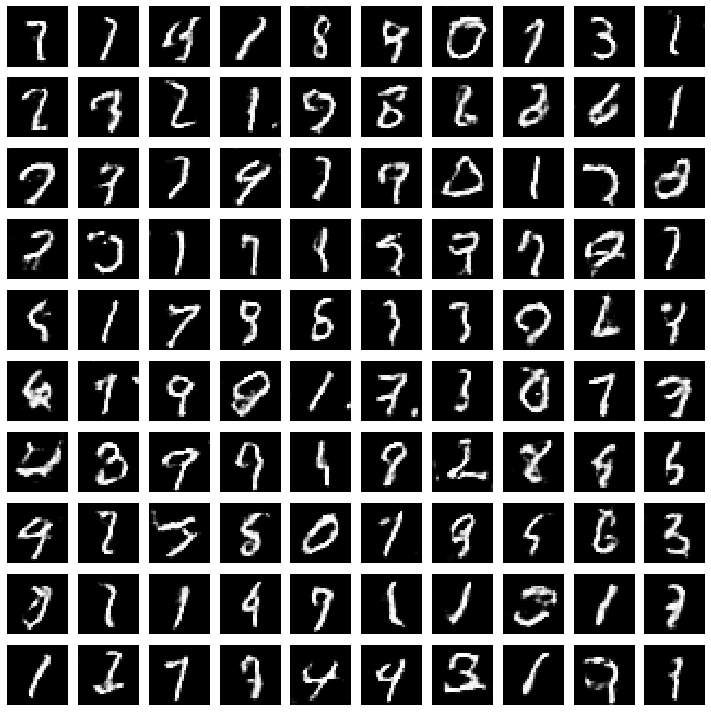

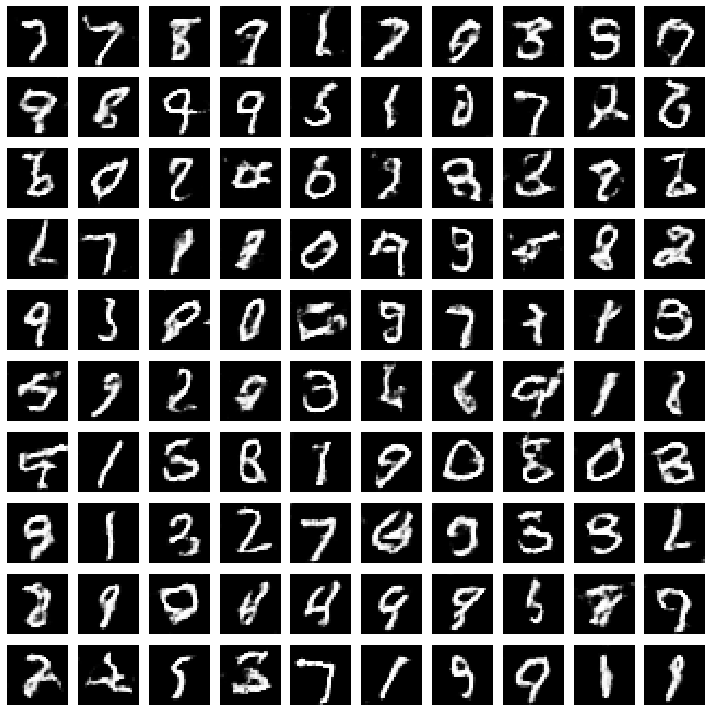

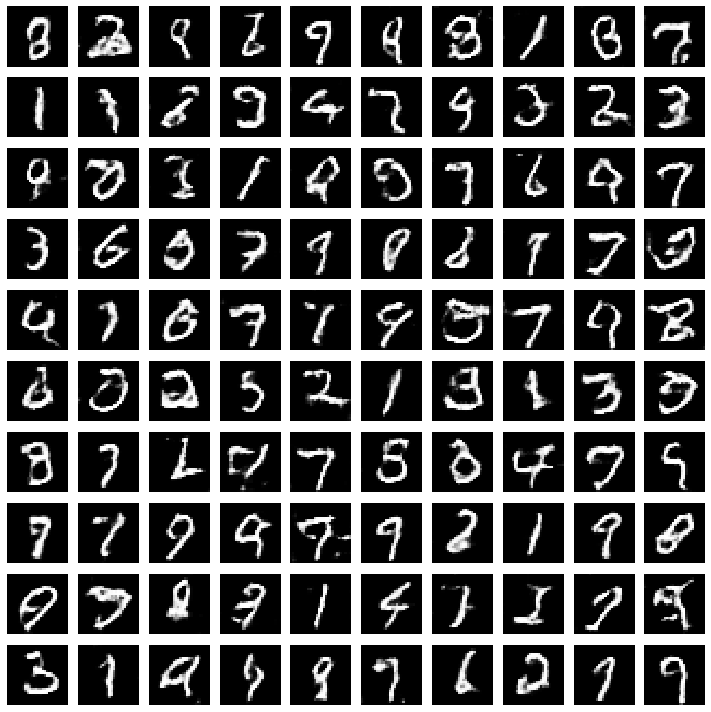

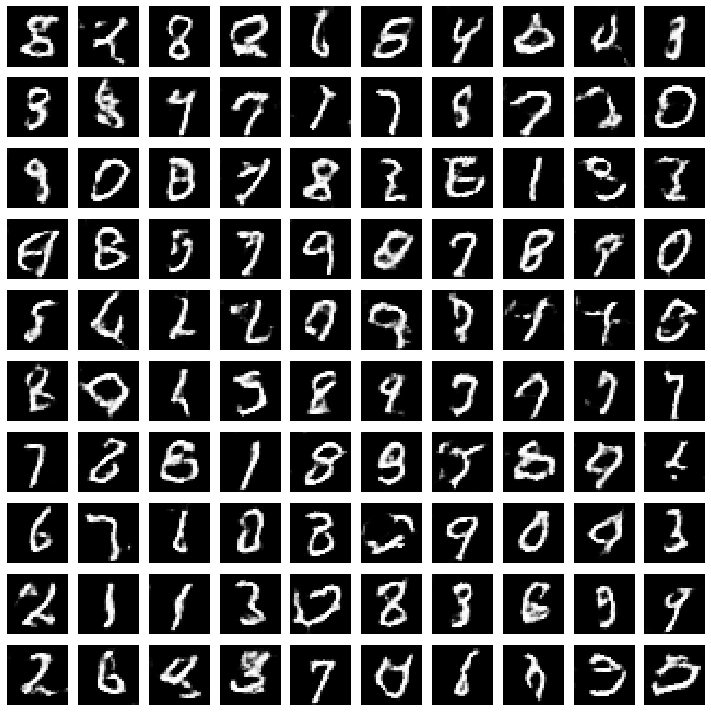

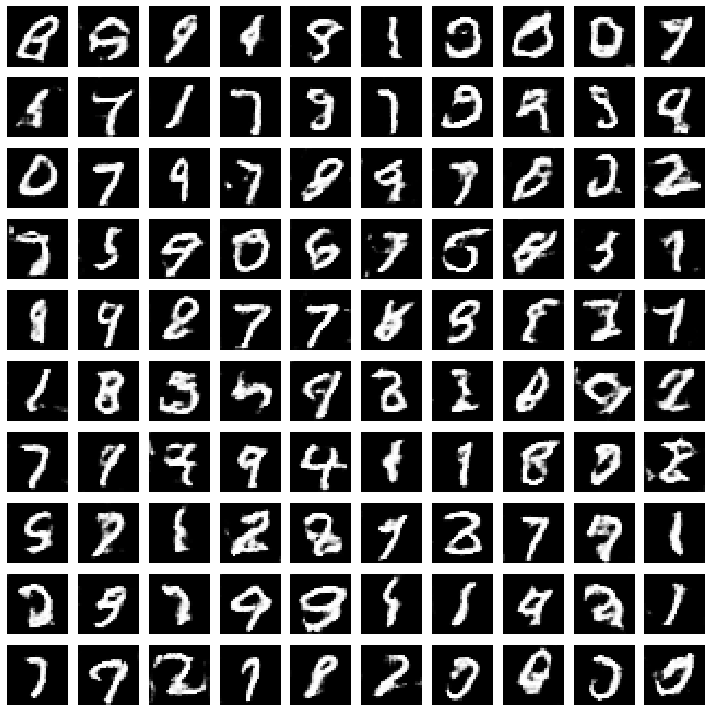

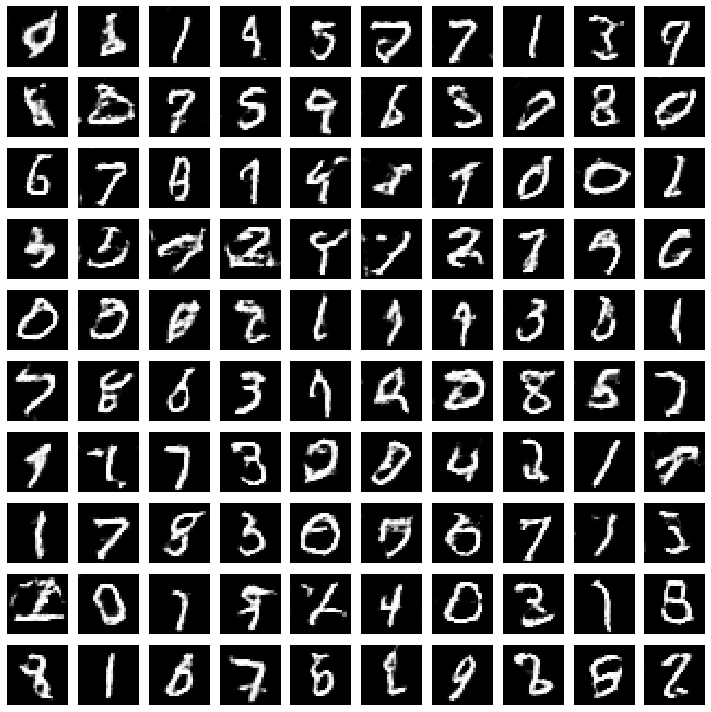

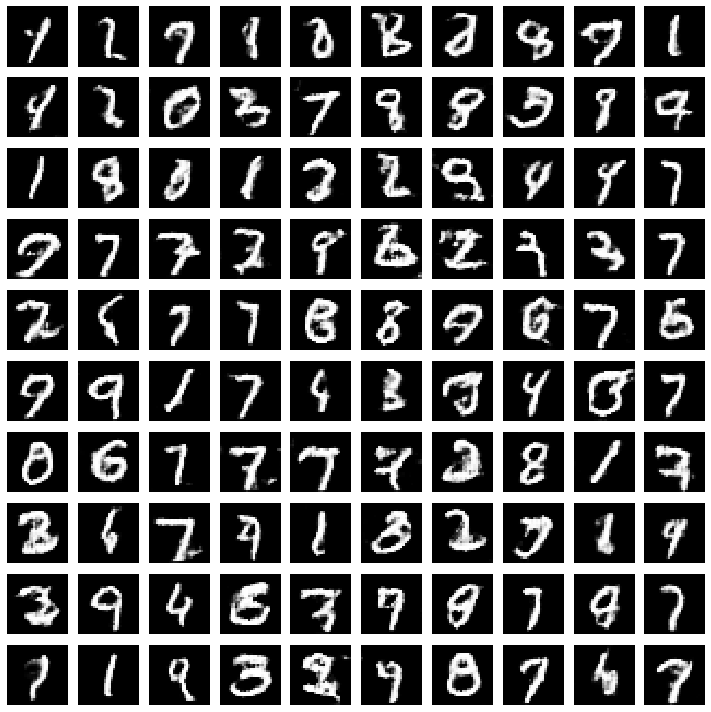

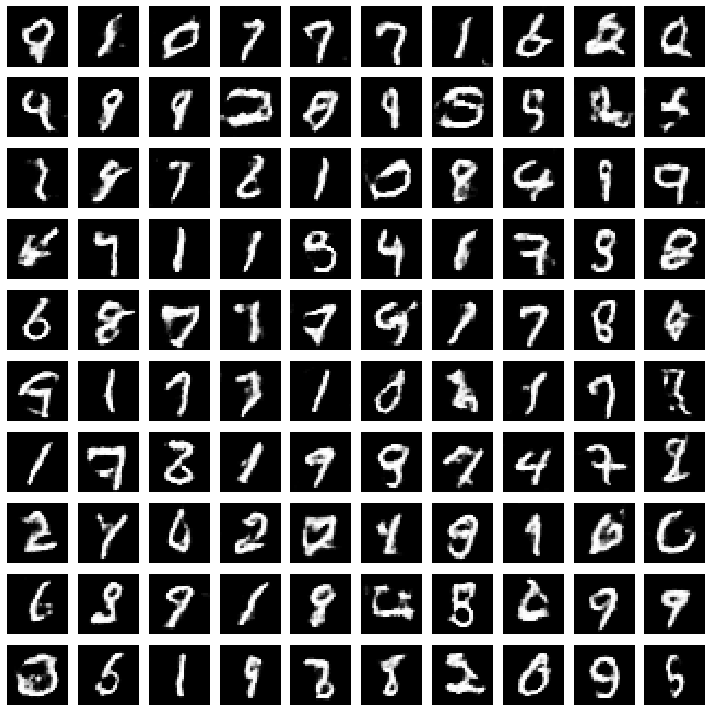

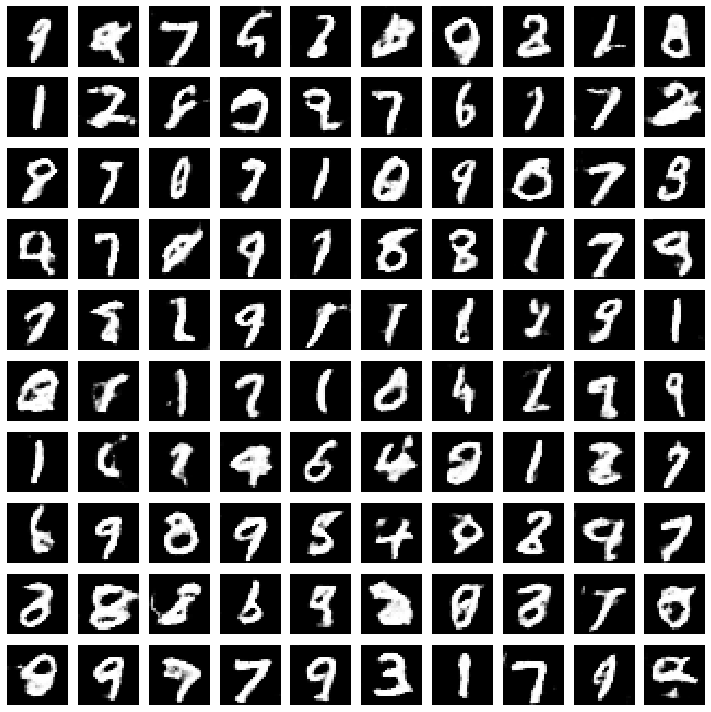

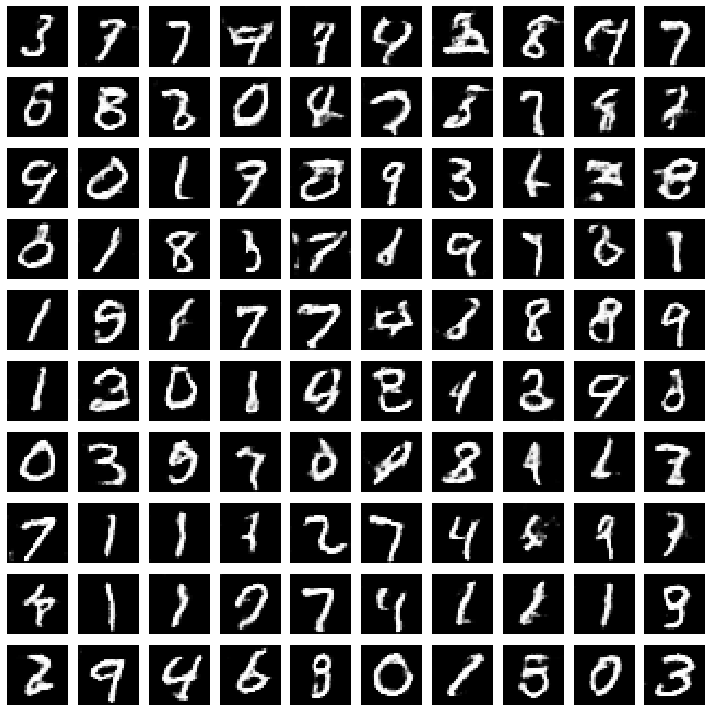

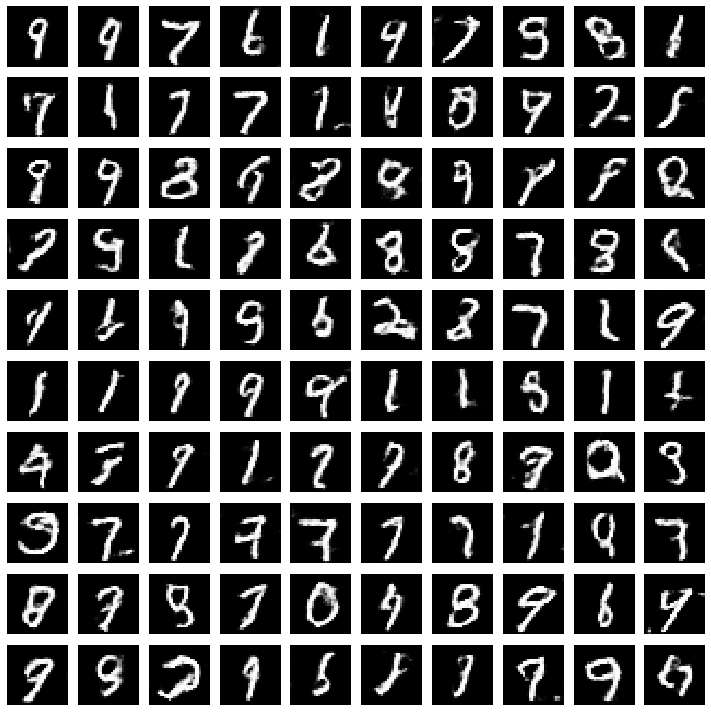

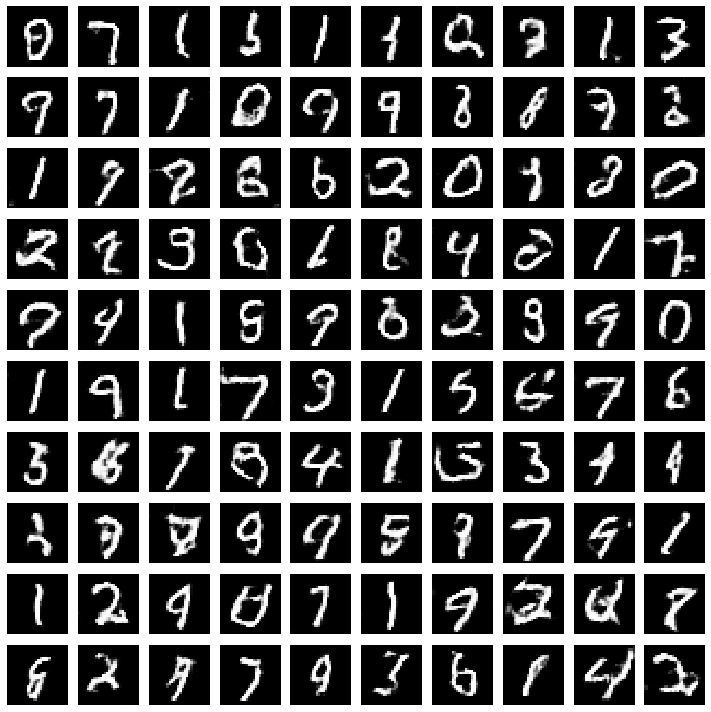

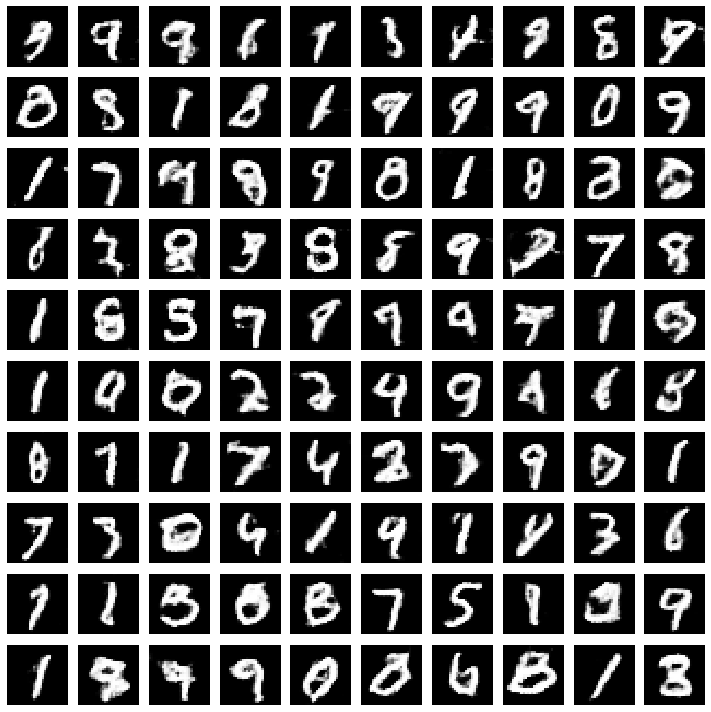

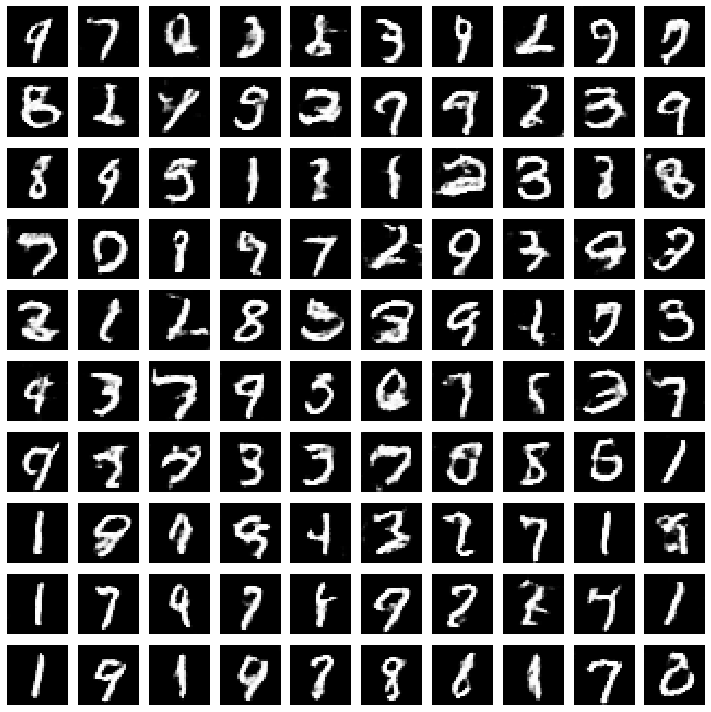

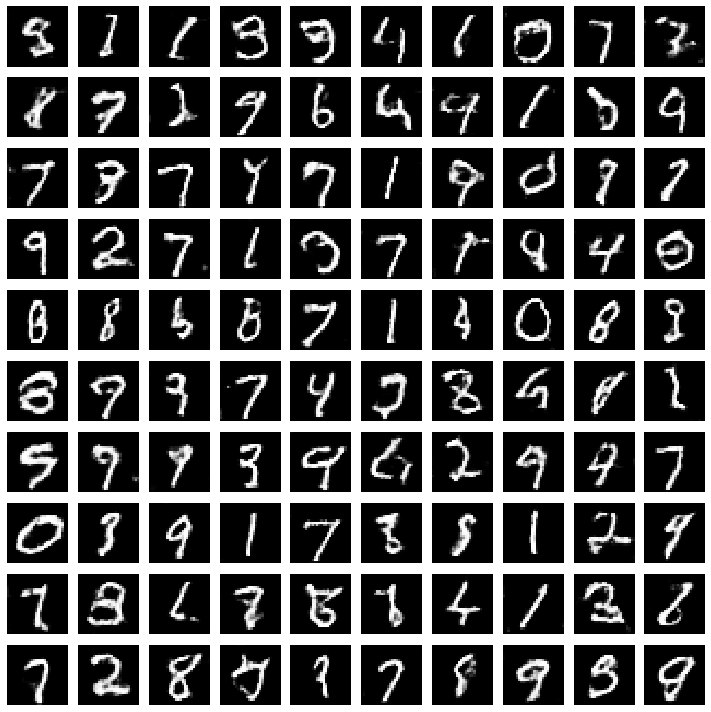

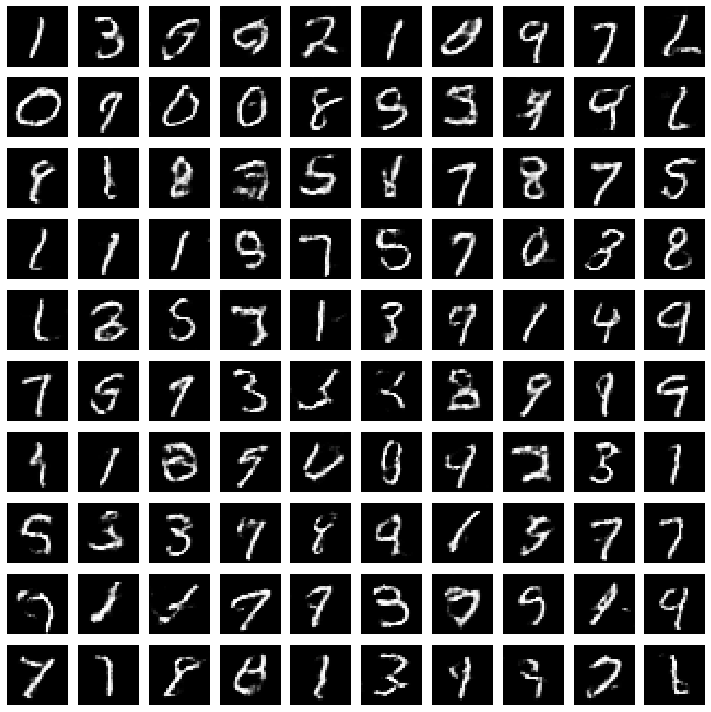

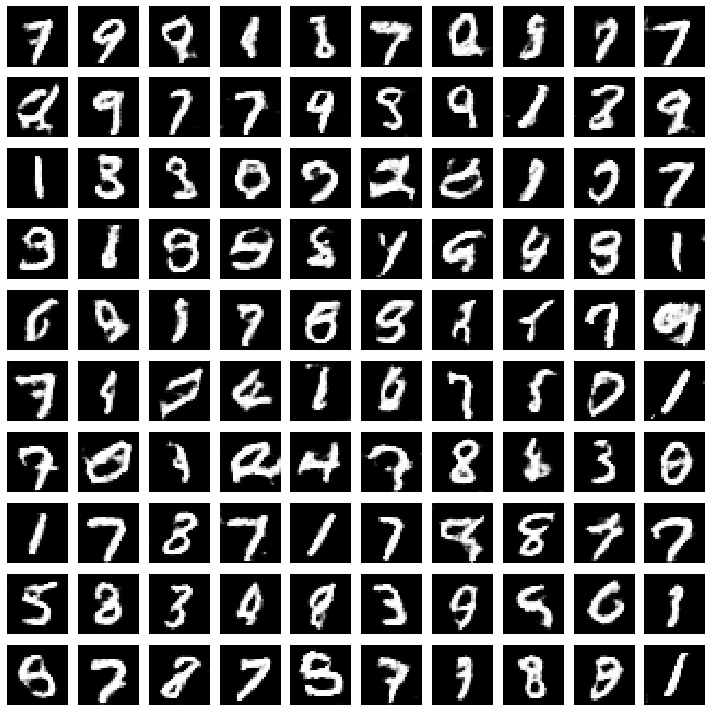

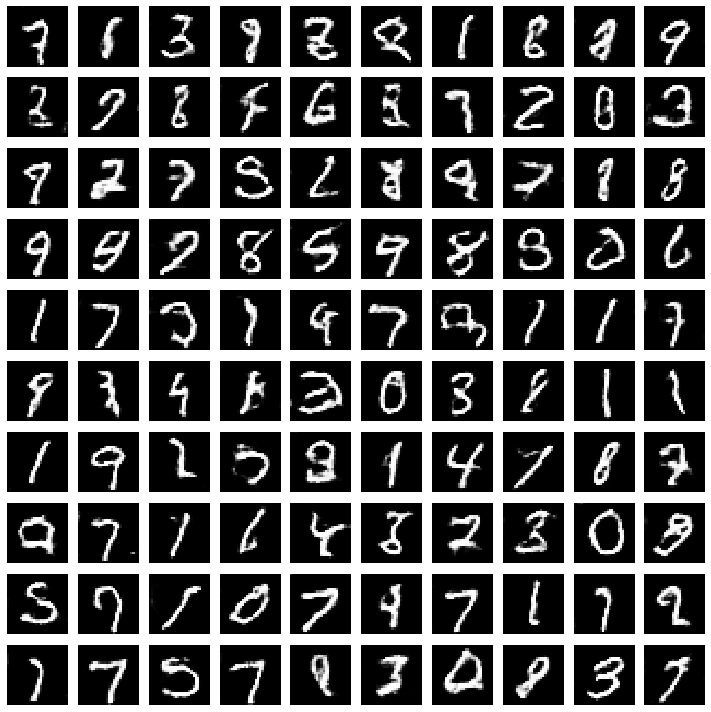

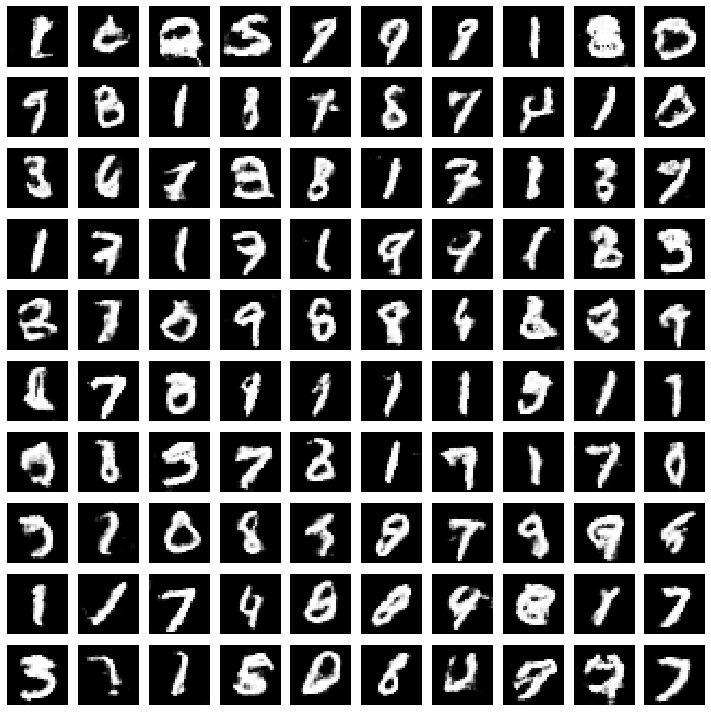

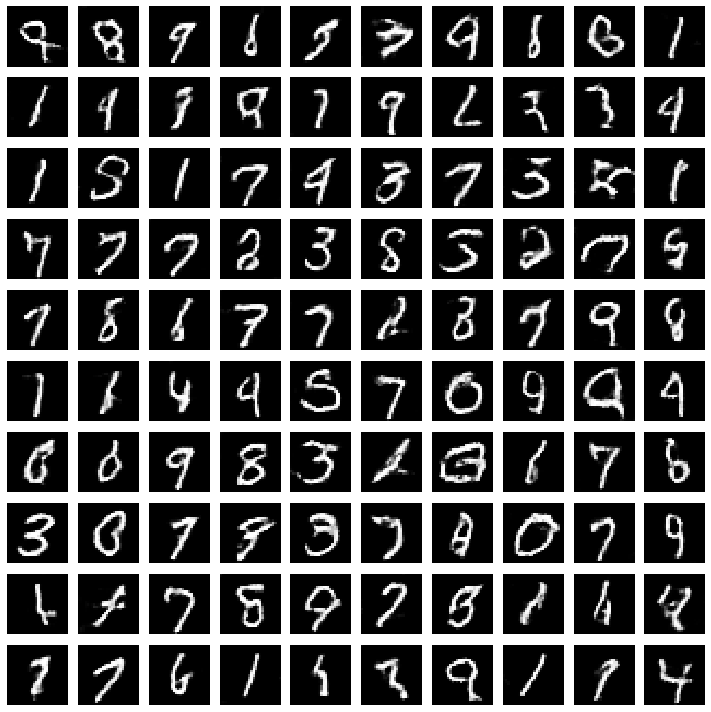

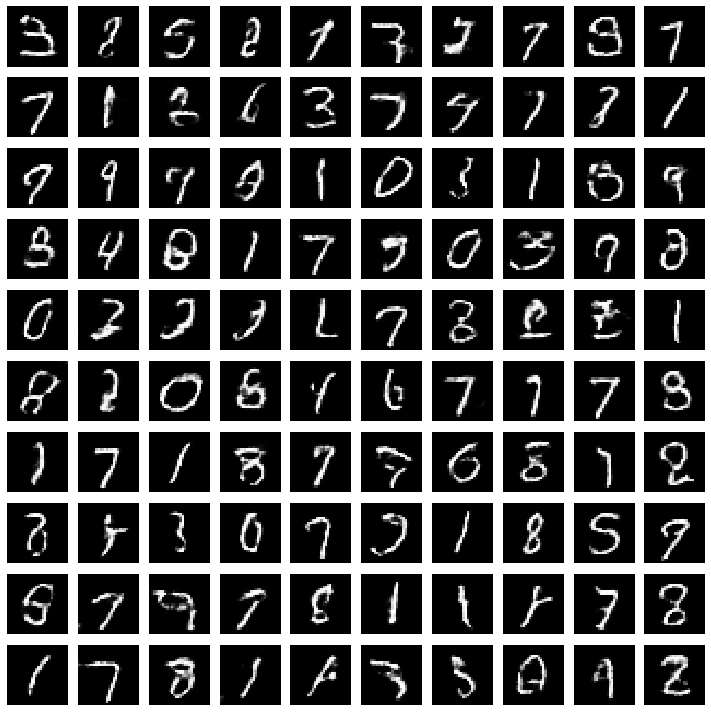

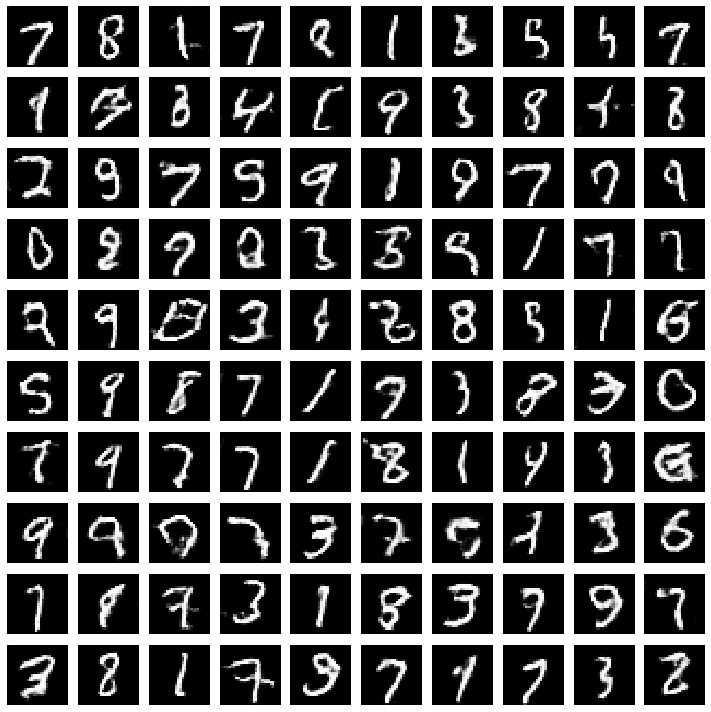

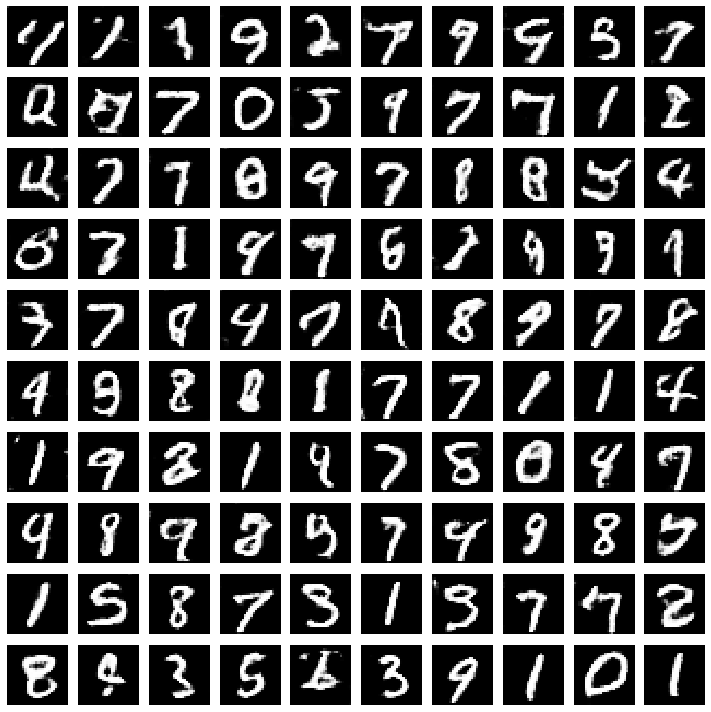

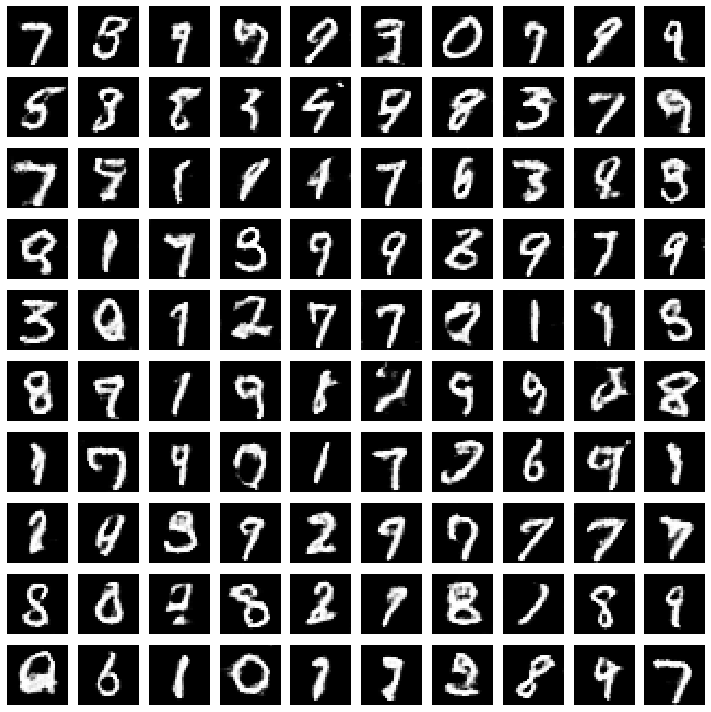

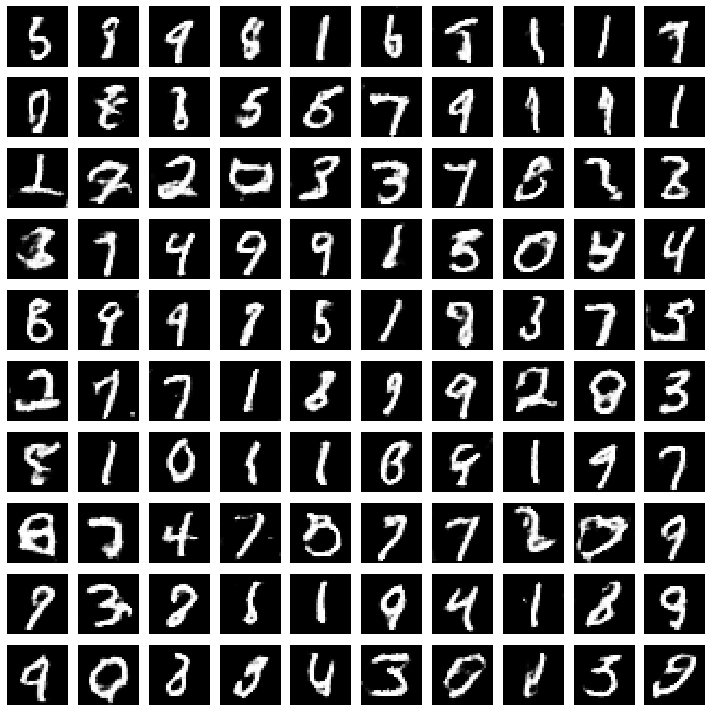

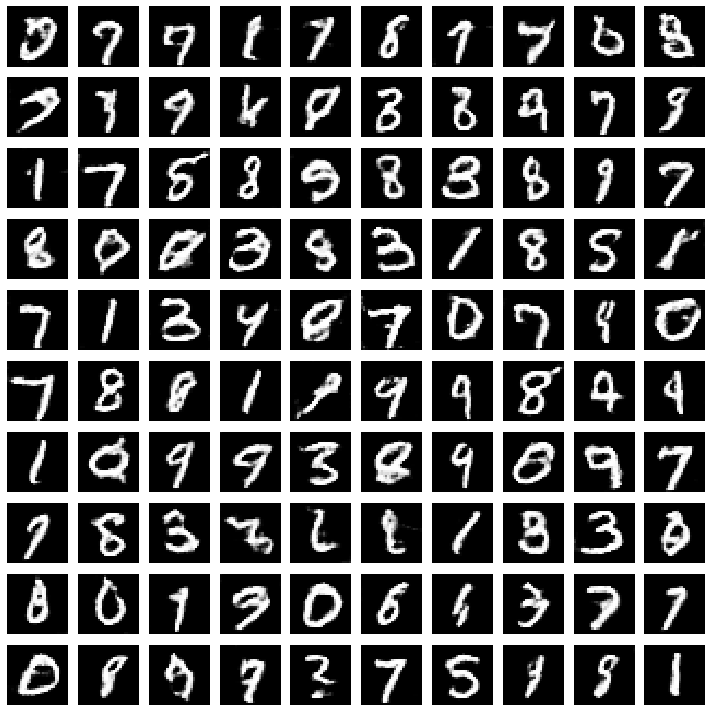

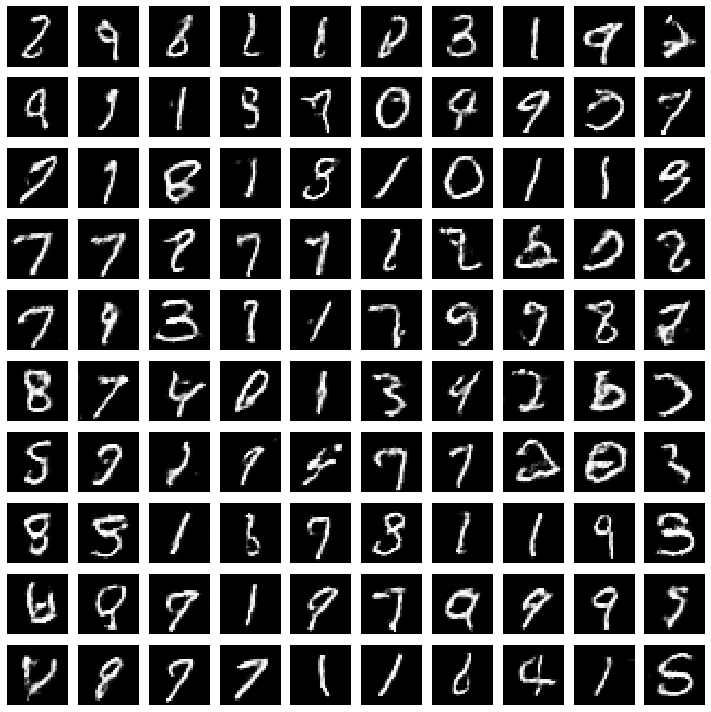

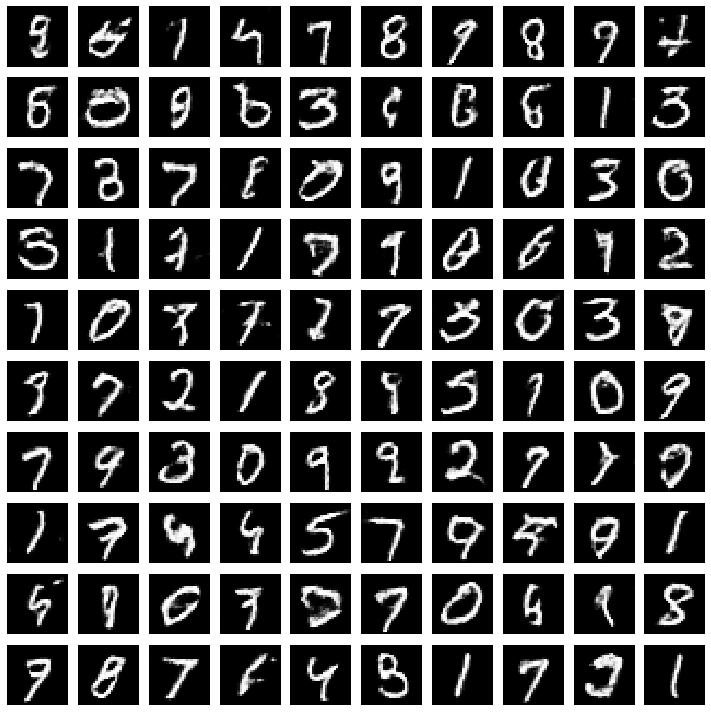

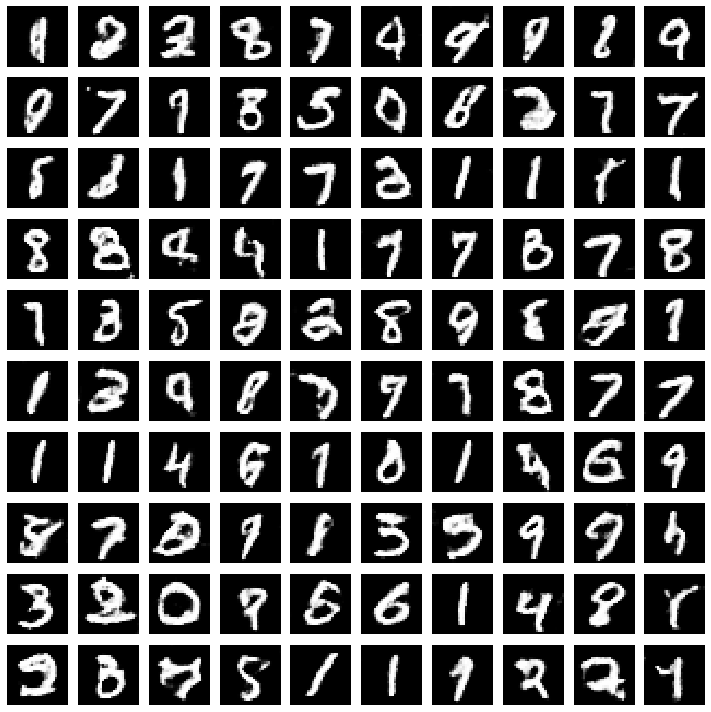

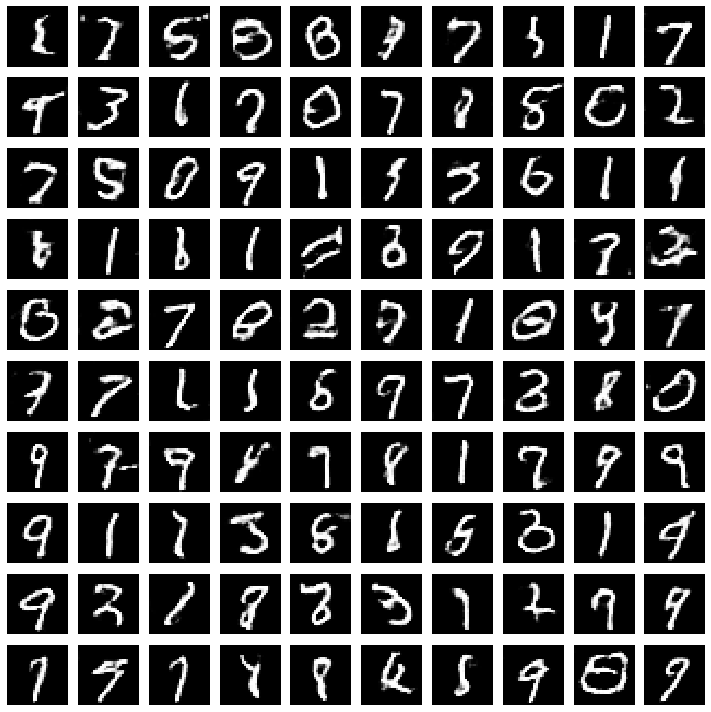

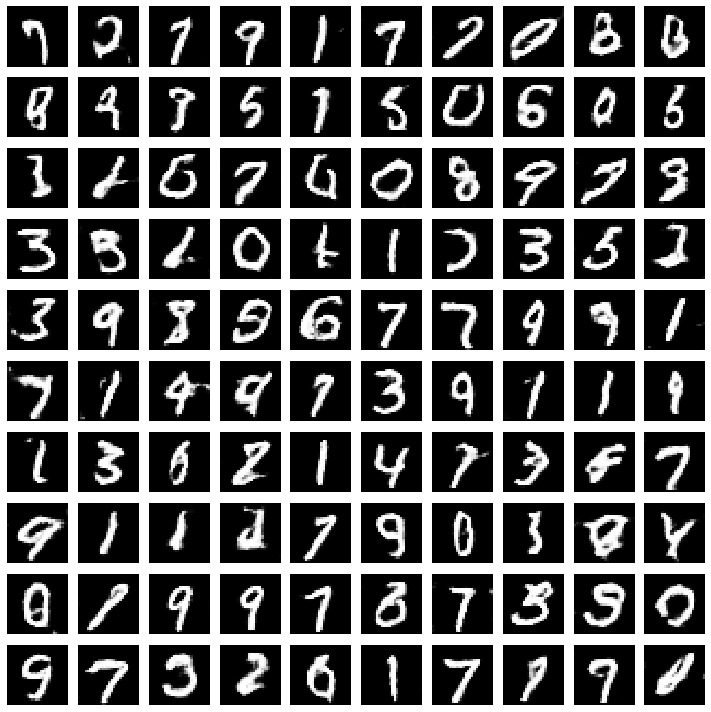

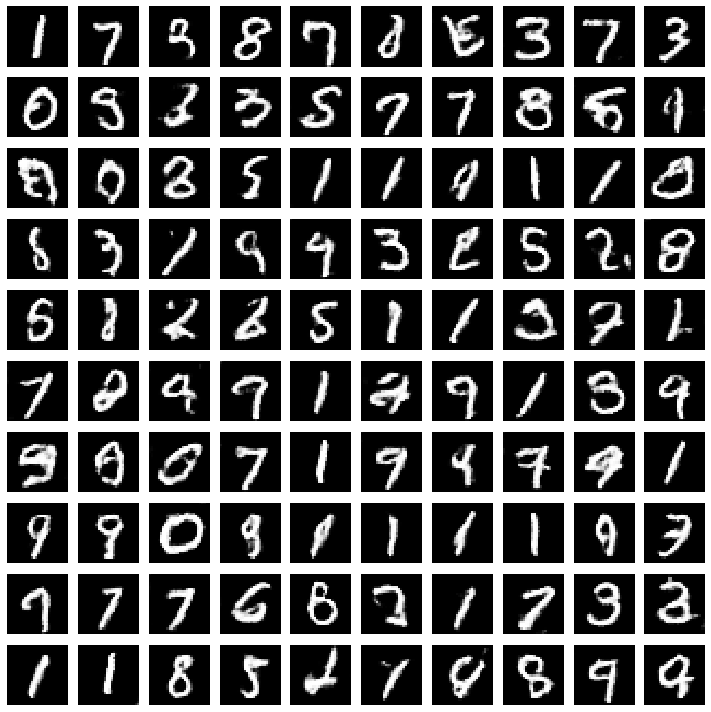

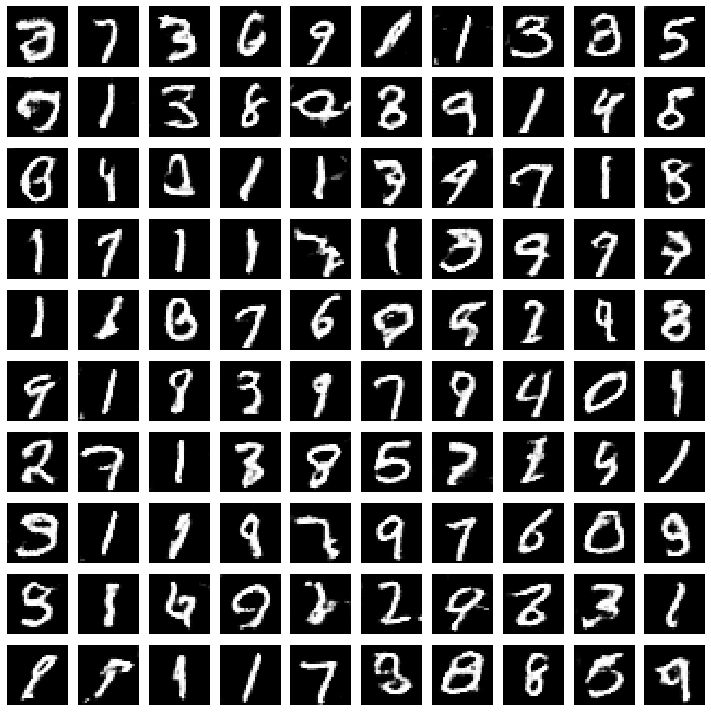

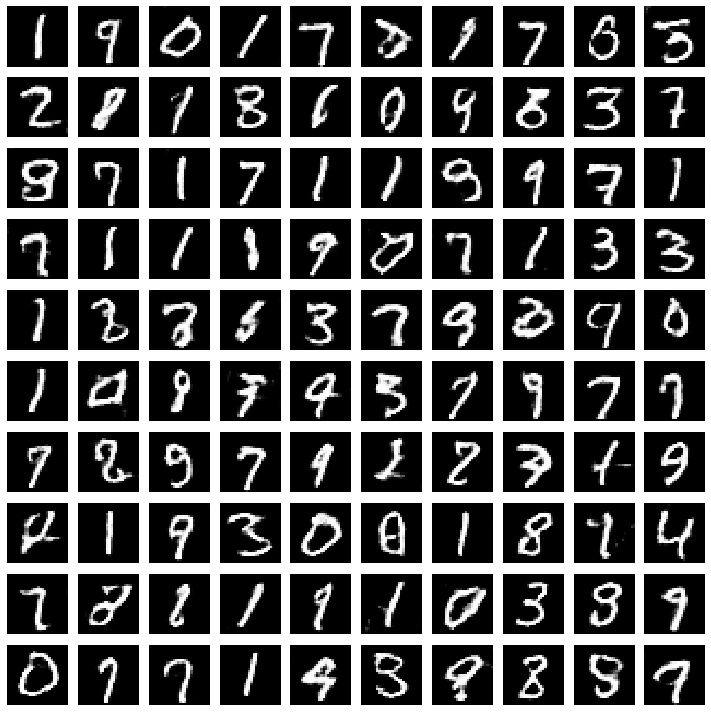

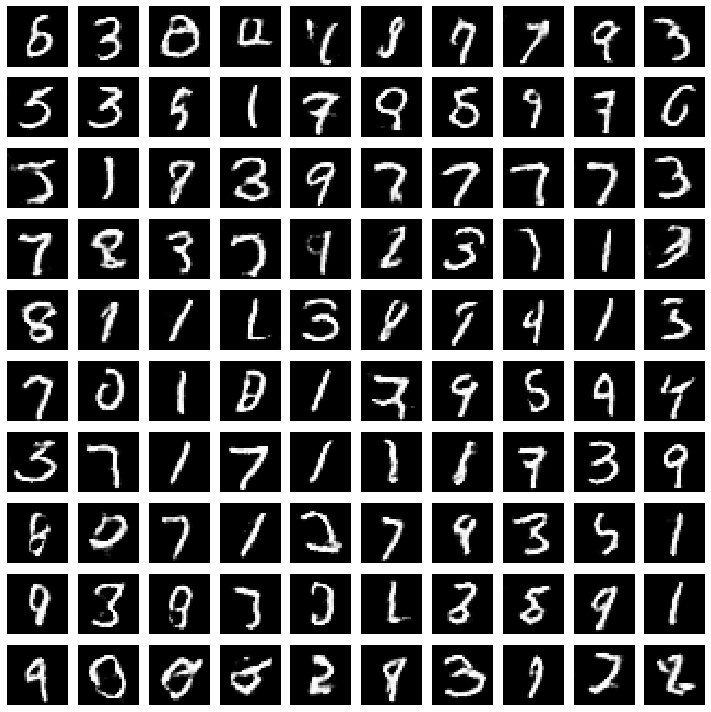

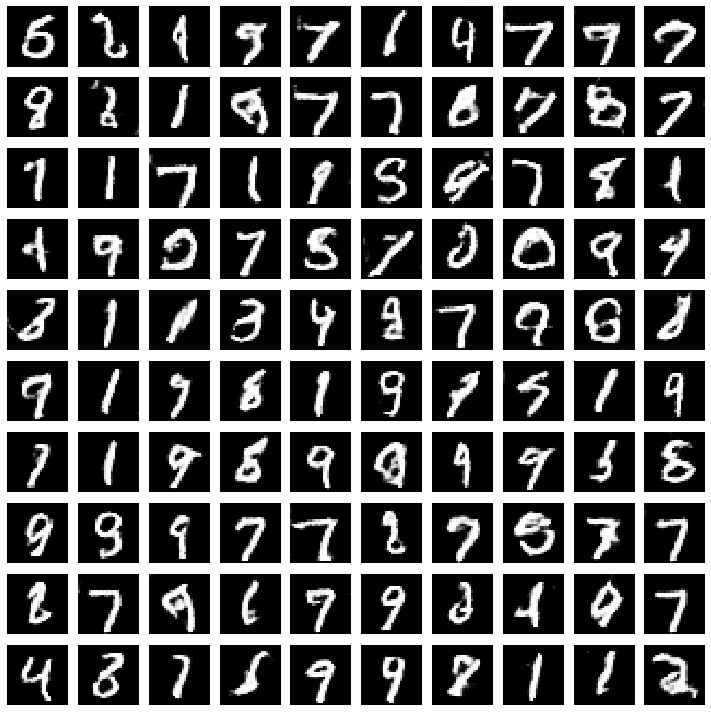

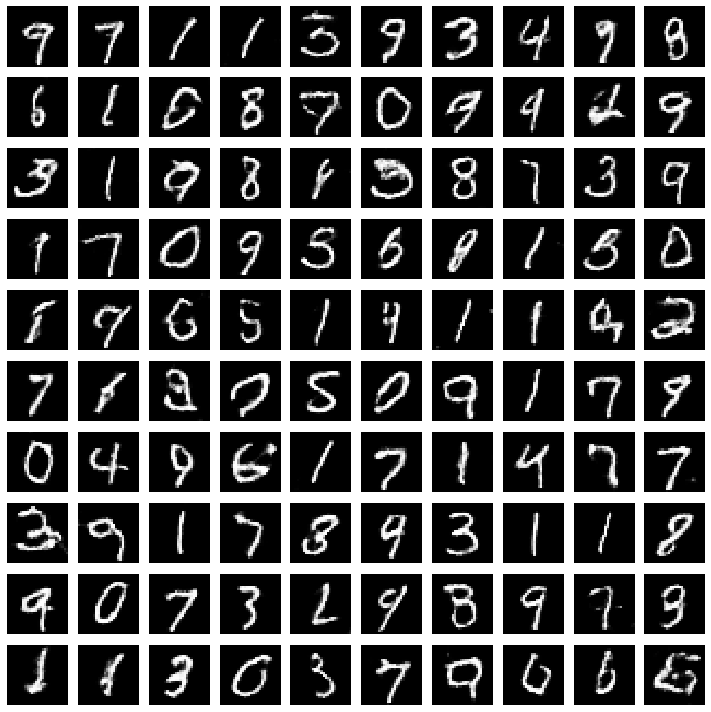

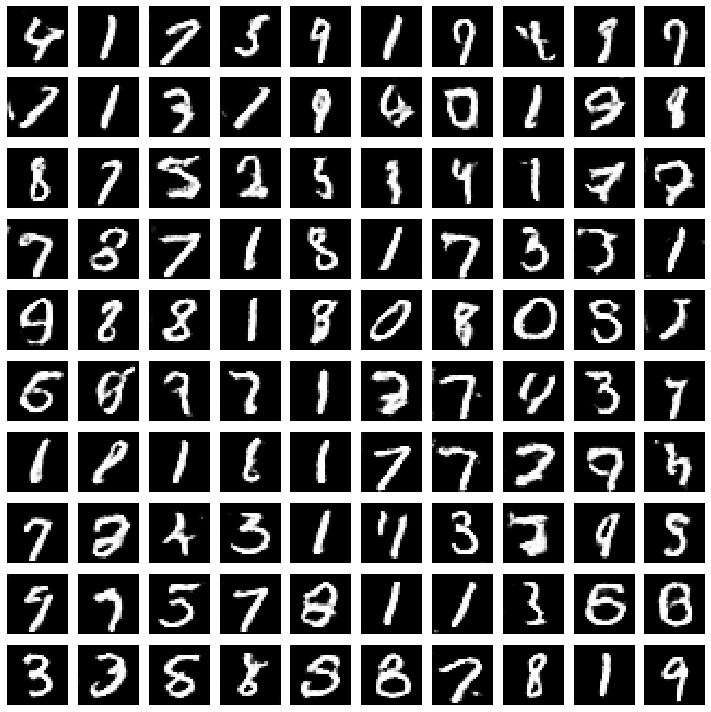

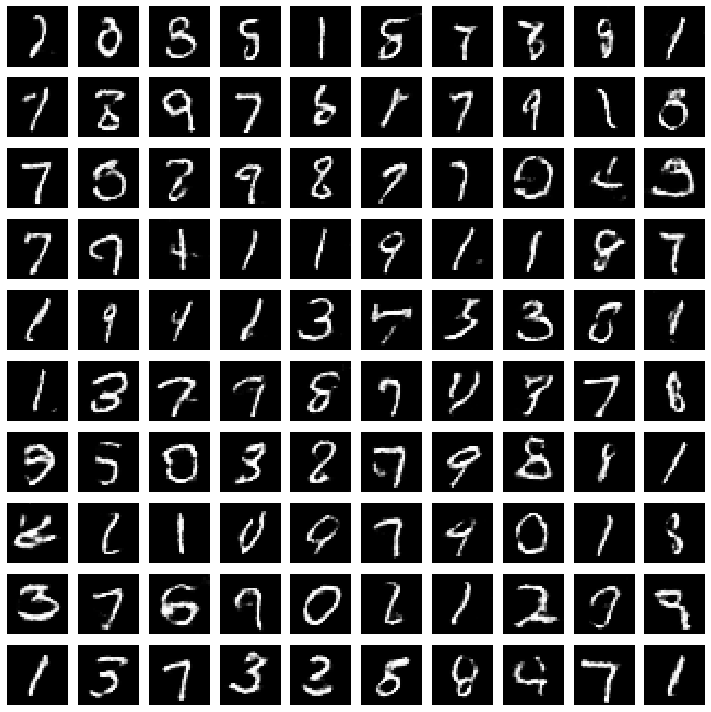

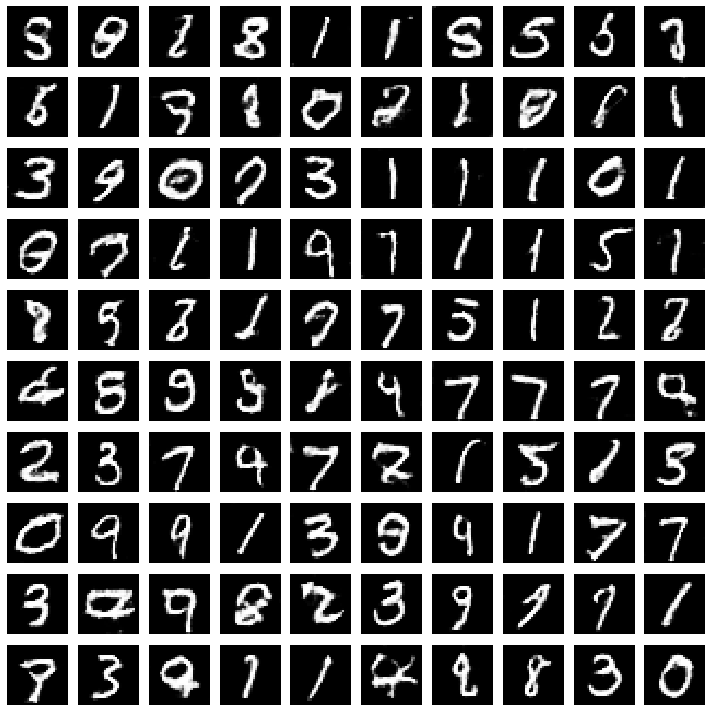

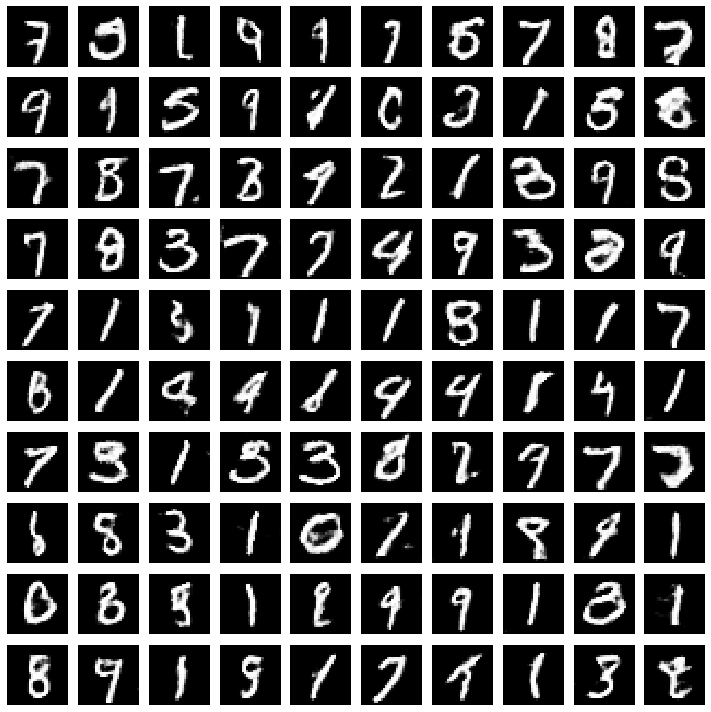

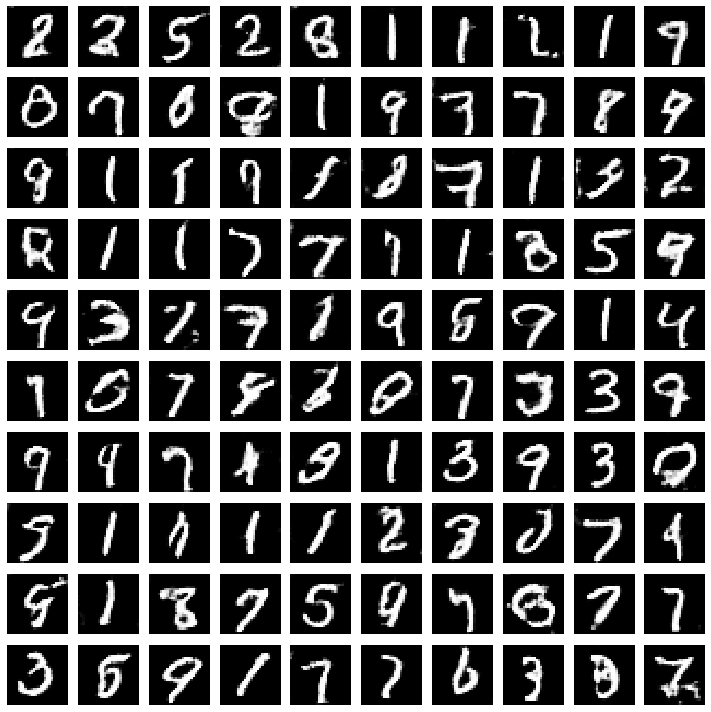

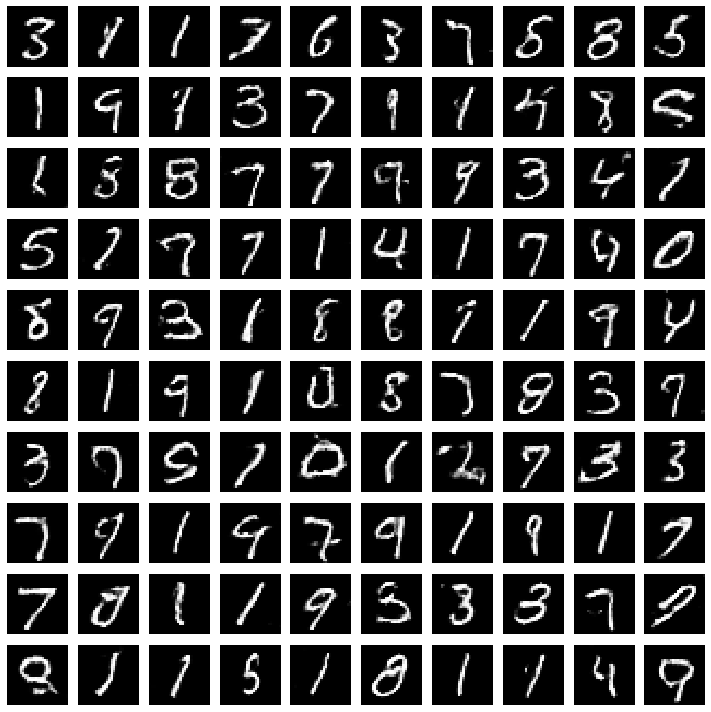

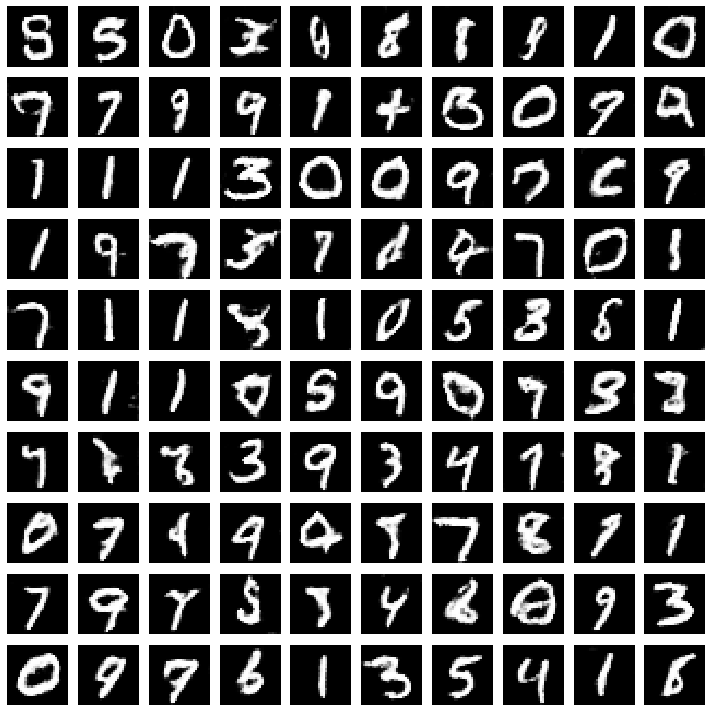

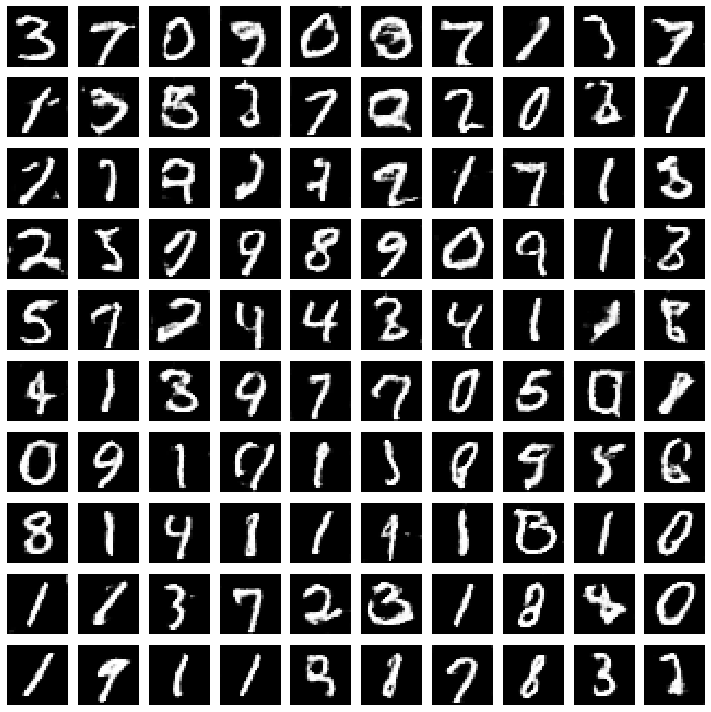

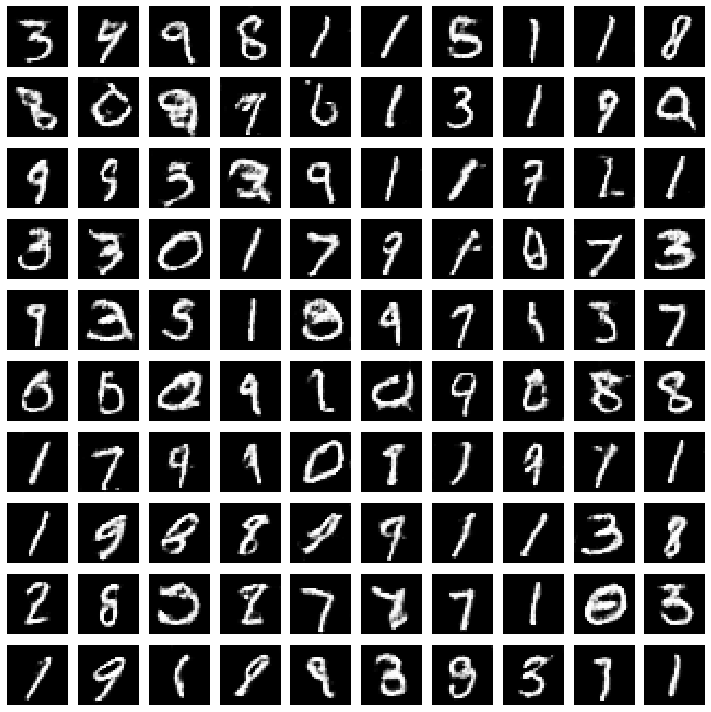

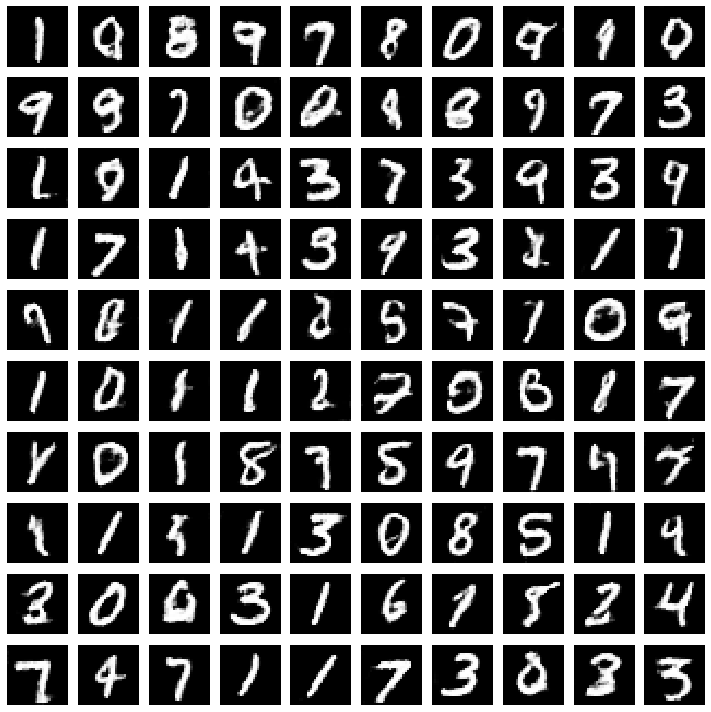

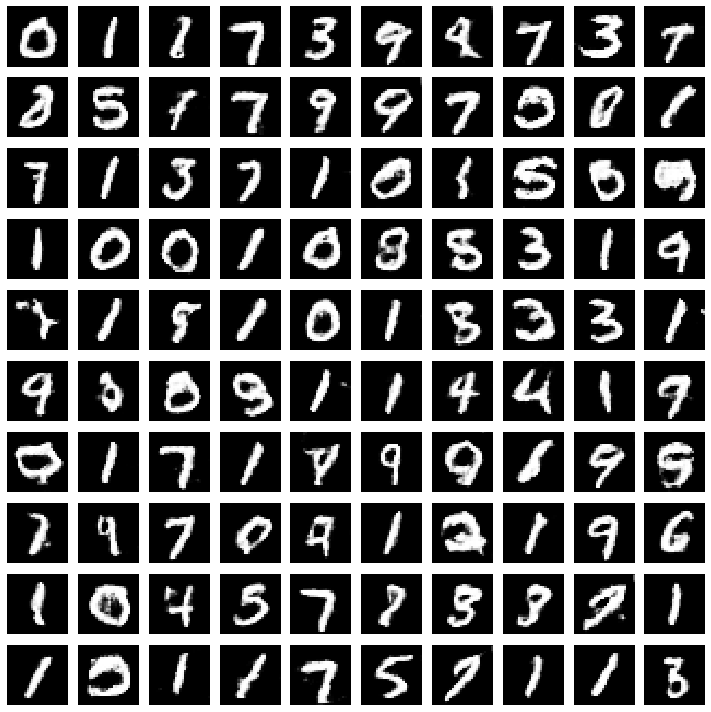

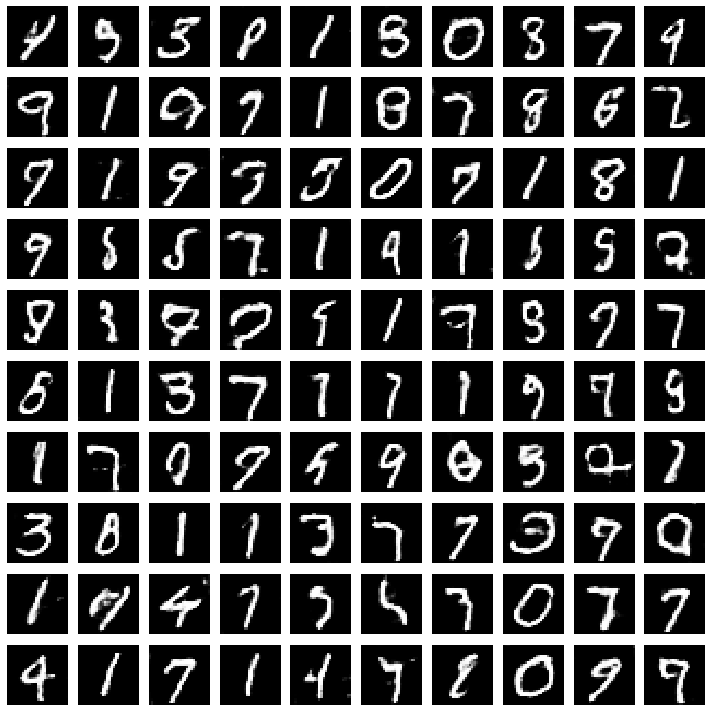

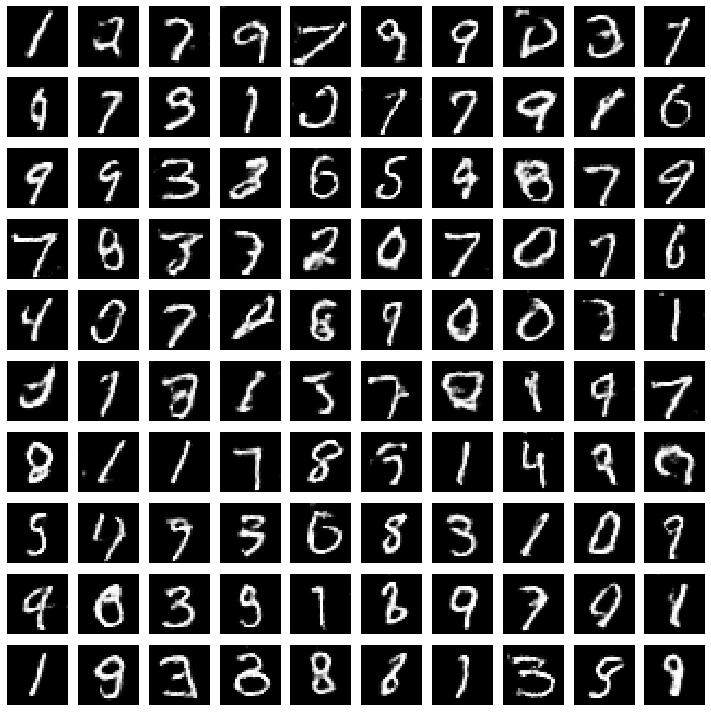

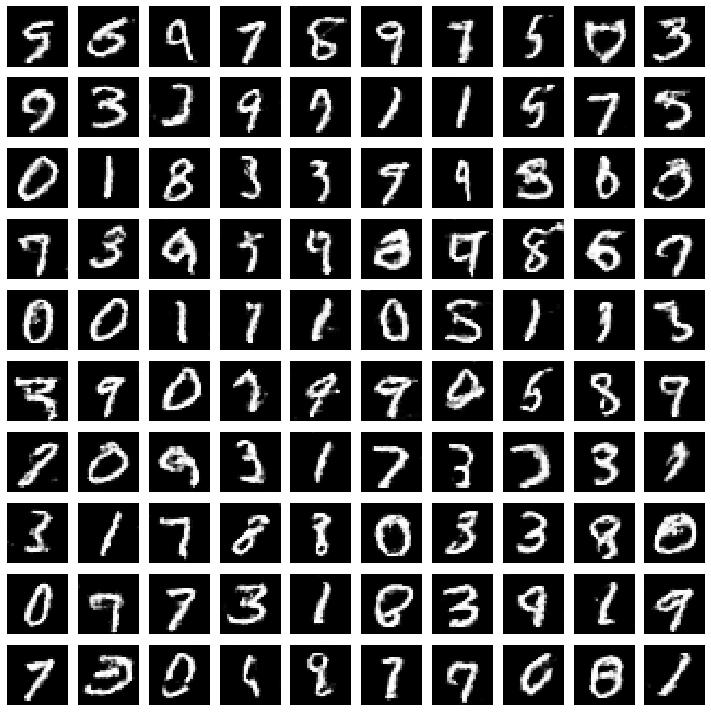

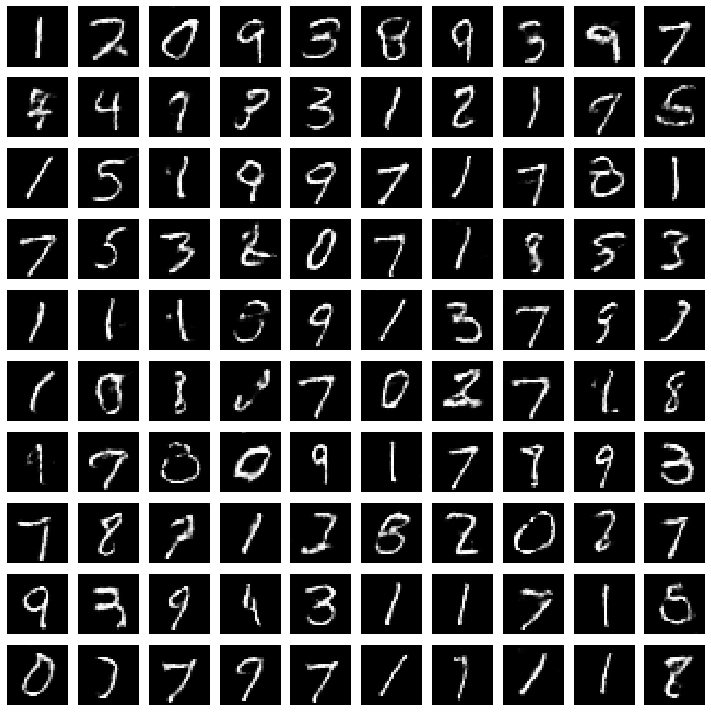

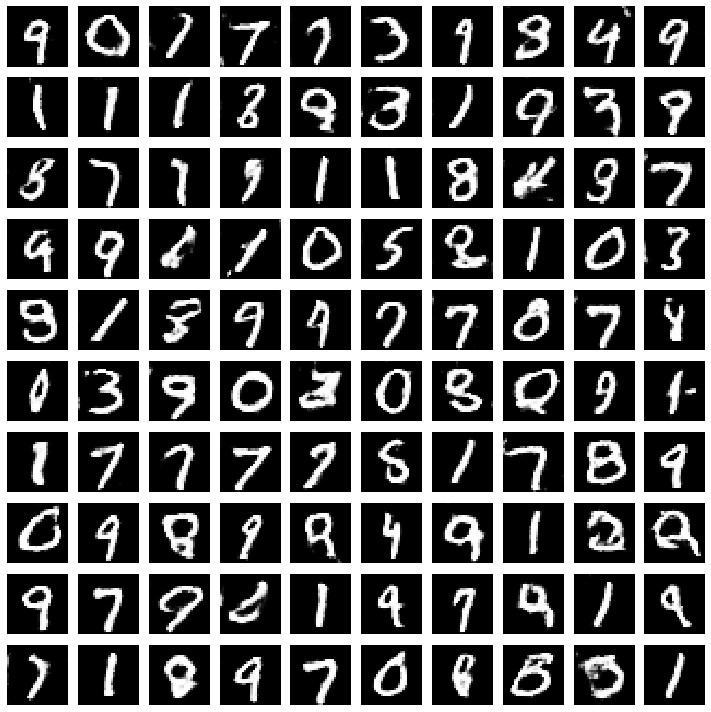

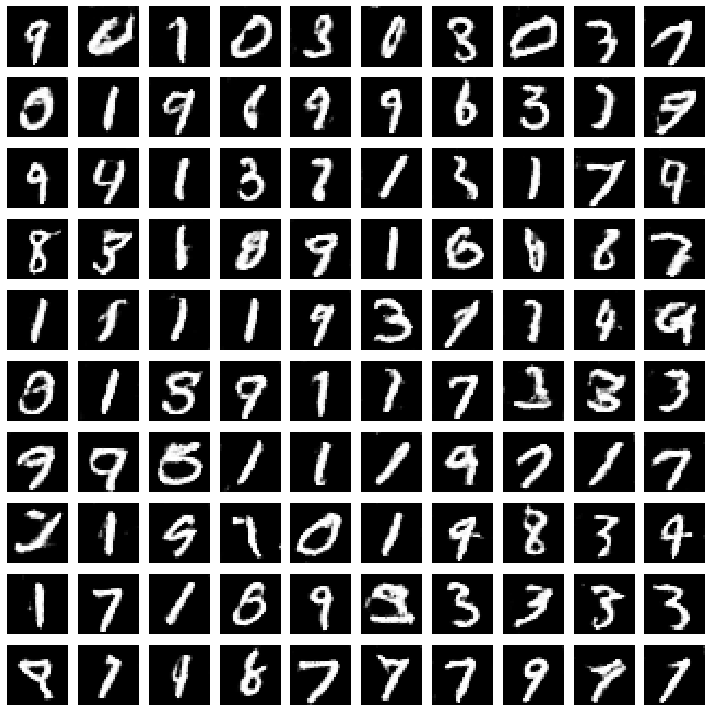

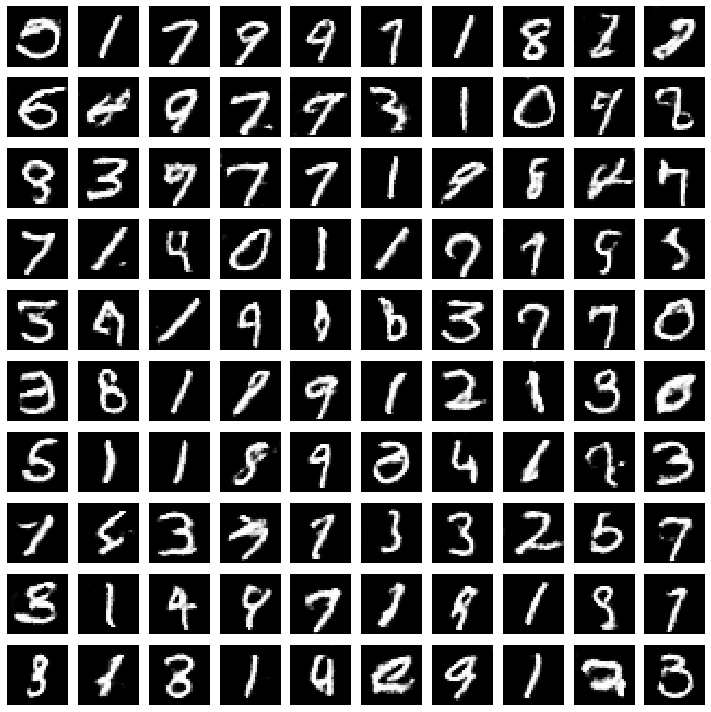

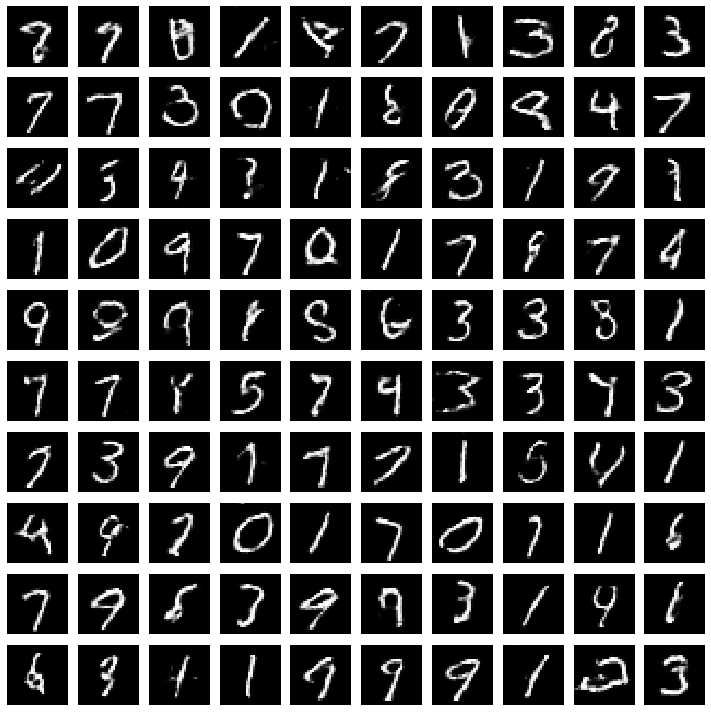

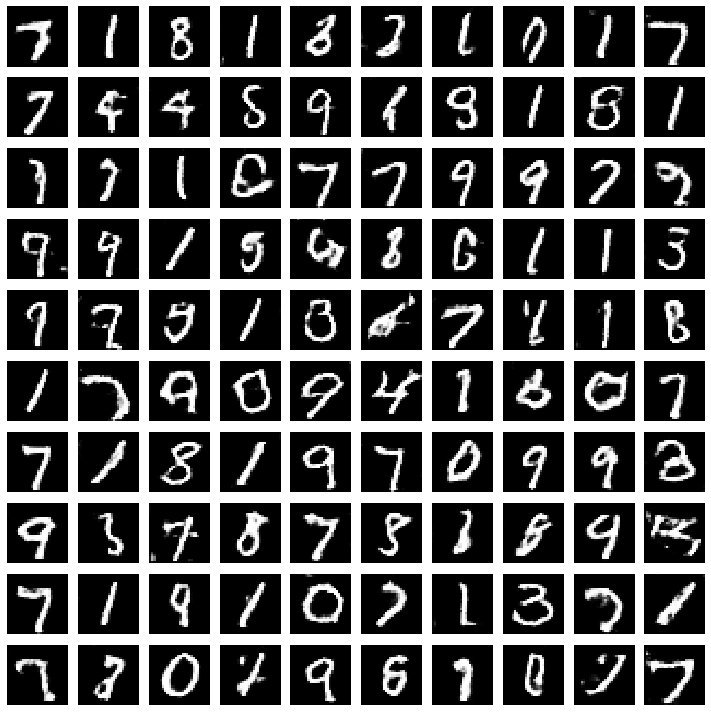

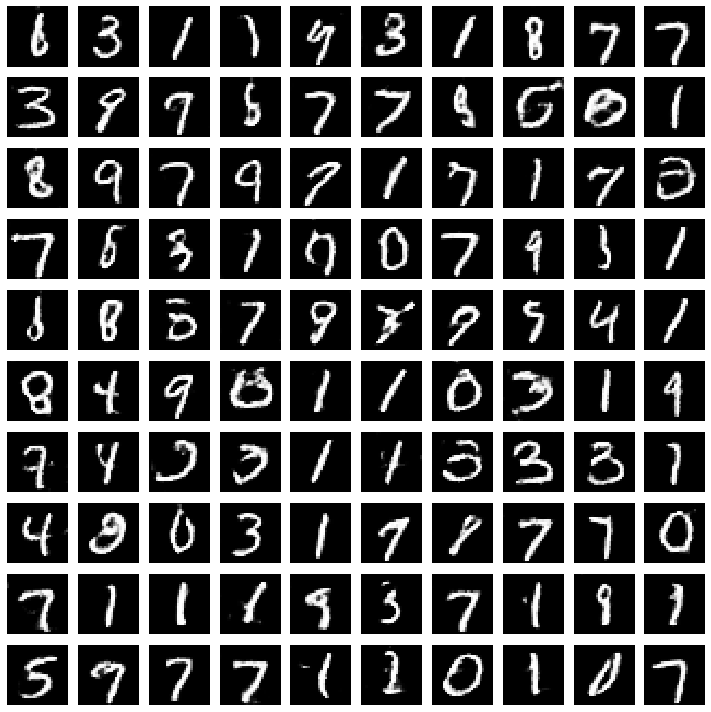

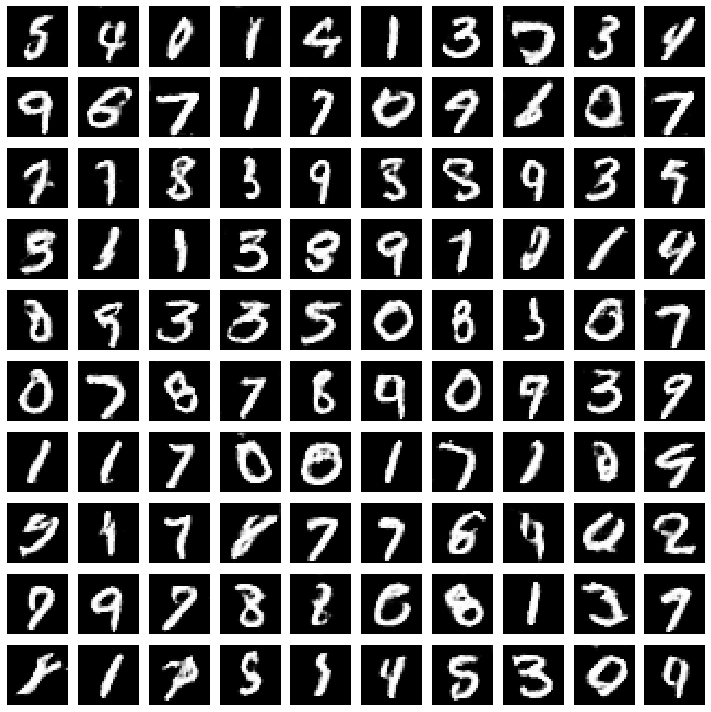

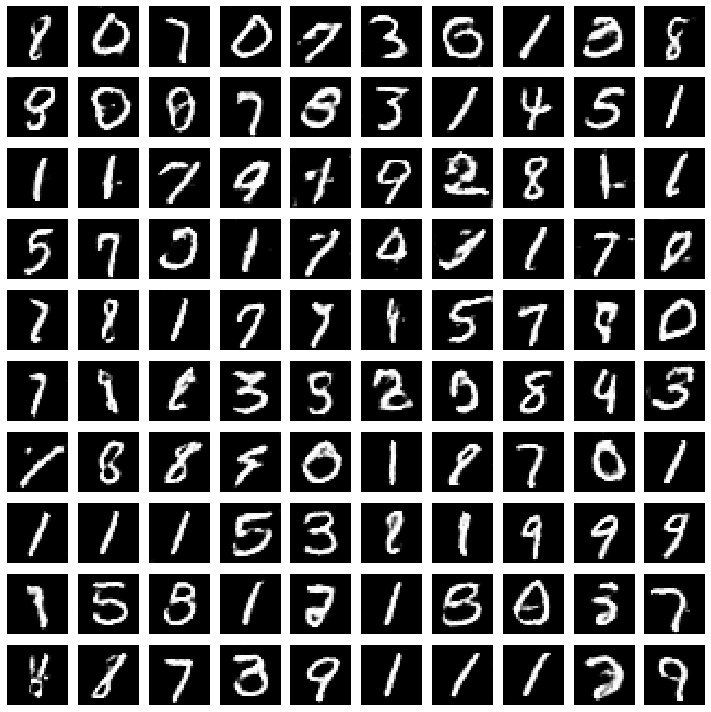

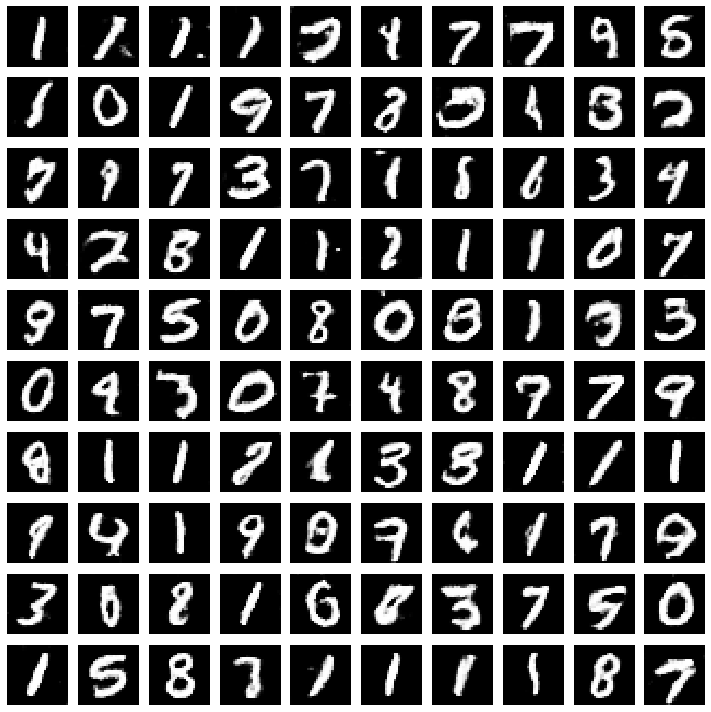

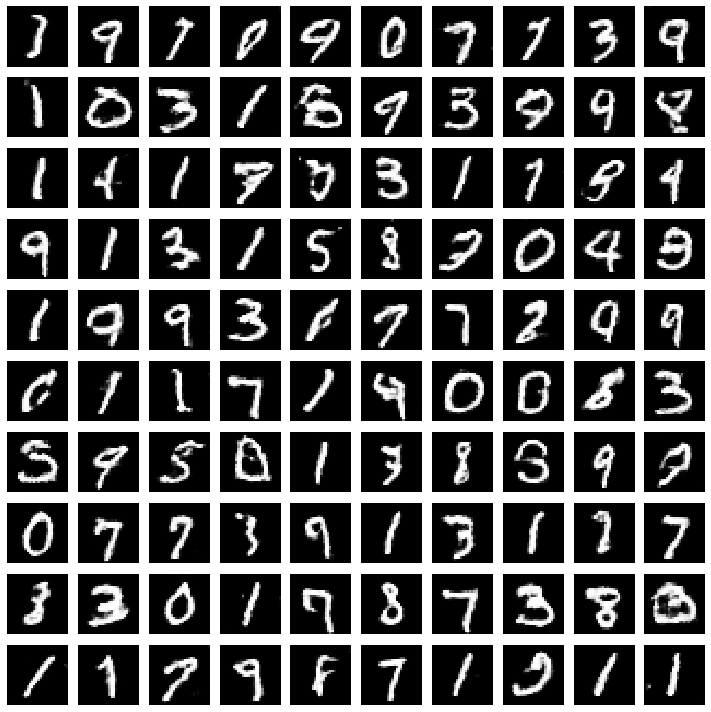

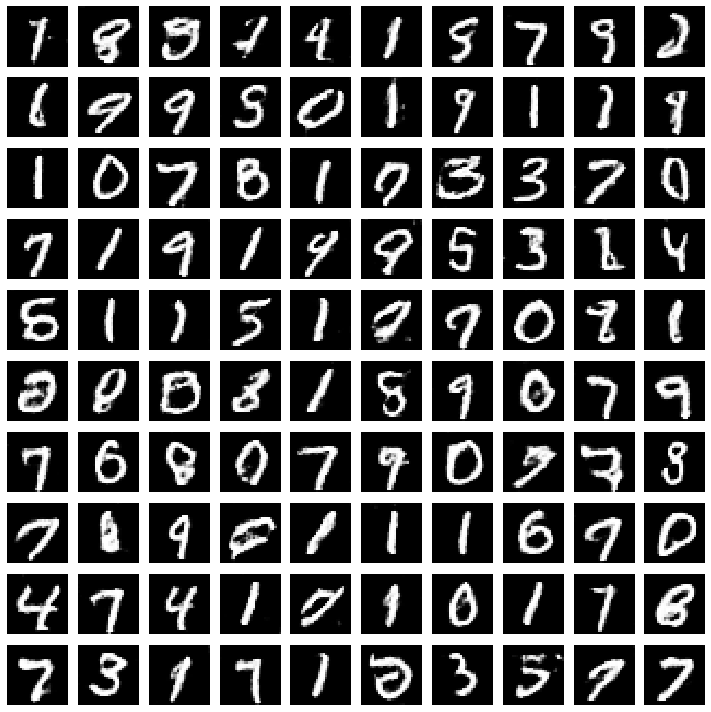

In [ ]:
train_GAN(train_dataset, 100)

In [ ]:
generator.save('generator4.h5')

In [ ]:
discriminator.save('discriminator4.h5')

In [ ]:
generator.predict

RuntimeError: ignored

In [ ]:
g = tf.keras.models.load_model('generator4.h5')

In [ ]:
g.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 49)                4900      
                                                                 
 batch_normalization_6 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 49)                0         
                                                                 
 dense_5 (Dense)             (None, 196)               9604      
                                                                 
 batch_normalization_7 (Batc  (None, 196)              784       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 196)              

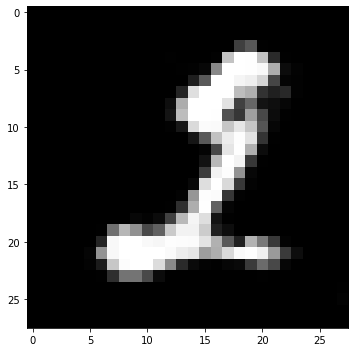

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_images = g.predict(noise)
# generated_images = generated_images.reshape(100,28,28)
dim=(10,10)
figsize=(5,5)
plt.figure(figsize=figsize)
# plt.figure()
# for i in range(generated_images.shape[0]):
#     plt.subplot(dim[0], dim[1], i+1)
#     plt.imshow(generated_images[i].reshape(28, 28), interpolation='nearest', cmap='gray')
#     plt.axis('off')
plt.imshow(generated_images.reshape(28, 28), interpolation='nearest', cmap='gray')
plt.tight_layout()
# plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
d = tf.keras.models.load_model('../c8v1/discriminator1.h5')
d.summary()

In [ ]:
d.predict(generated_images)

array([[-0.28663963]], dtype=float32)